#### Day 1

In [1]:
import math
import itertools
import re
import json
import random

import numpy as np
import pandas as pd
import networkx as nx

from random import randint
from collections import Counter, defaultdict
from copy import deepcopy

from matplotlib import pyplot as plt

%matplotlib inline

In [773]:
class IntCode_v3:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
#         self.work_intcode = self.intcode[:]
        self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode.get(num, 0)
        elif mode == 1:
            return num
        elif mode == 2:
            return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
    def spec_mode_manage(self, num, mode):
        if mode == 0 or mode == 1:
            return num
        elif mode == 2:
            return self.mem['relbase'] + num
                
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode.get(current_idx, 0))
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0)) 
                selfmem['inputs'][selfmem['input_idx']]
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                
                selfmem['input_idx'] += 1
                current_idx += 2
                
            except IndexError:
#                 print('HALT COMMAND')
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
            output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        
        elif int(opcode) == 9:
            rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
            selfmem['relbase'] += rel_adj
                
            current_idx += 2
        
        return current_idx
       
    def intcodeRead(self, calc = 'input', outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            self.mem['relbase'] = 0
            
            if isinstance(self.mem.get('inputs',0), int):
                self.mem['inputs'] = [self.mem.get('inputs',0)]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
#                 f'Calculating using input method\n'
#                 f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
            self.mem['current_idx'] = self.instr_manage(self.mem)

        reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
        if outmode == 1:
            return reconstituted, self.output
        elif outmode == 'output_only':
            return self.output
        elif outmode == 'last_out':
            return self.output[-1]
        else:
#             print(reconstituted, self.output, self.mem.get('inputs'))
            print(self.mem.get('inputs'), self.output)

In [3]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += math.trunc(float(x)/3) -2

solution

3336439

In [4]:
def fuel_calc(num: float) -> float:
    calc = math.trunc(num/3) - 2
    if calc > 0:
        return calc
    else:
        return 0

In [5]:
with open('day01.txt', 'r') as file:
    solution = 0
    for x in file.readlines():
        solution += fuel_calc(float(x))

        add_fuel = fuel_calc(fuel_calc(float(x)))
        solution += add_fuel

        while fuel_calc(add_fuel) > 0: 
            add_fuel = fuel_calc(add_fuel)
            solution += add_fuel

solution

5001791

#### Day 2

In [6]:
with open('day02.txt', 'r') as file:
    intcode = [int(x) for x in file.read().split(',')]
    intcode[1] = 12
    intcode[2] = 2

In [7]:
class IntCode:
    def __init__(self, intcode, noun, verb):
        self.intcode = intcode
        self.noun = noun
        self.verb = verb
    
    @classmethod
    def load_txt(cls, filename):
        with open(filename, 'r') as file:
            return cls(intcode = [int(x) for x in file.read().split(',')], noun = intcode[1], verb = intcode[2])
    
    @staticmethod
    def manual_read(target, test=0):
        x = target[:]
        for num in range(0, len(x), 4):
            current_op = x[num]

            if current_op == 99:
                break
            else:
                input_loc1 = x[num+1]
                input_loc2 = x[num+2]
                output_loc3 = x[num+3]
                if current_op == 1:
                    x[output_loc3] = x[input_loc1] + x[input_loc2]
                elif current_op == 2:
                    x[output_loc3] = x[input_loc1] * x[input_loc2]

            if test == 1:
                break

        return x[0]
    
    def intcodeRead(self, noun=-1, verb=-1, test = 0):
        x = self.intcode[:]
        if noun == -1 or verb == -1:
            print(f'No valid noun/verb pair, using default Noun: {self.noun}, Verb:{self.verb}')
            x[1] = self.noun
            x[2] = self.verb
        else:
            x[1] = noun
            x[2] = verb

        result = self.manual_read(x, test)
        return result

    def brute_force(self, target):
        noun_t = randint(0, 100)
        verb_t = randint(0, 100)
        
        while self.intcodeRead(noun=noun_t, verb=verb_t) != target:
            print(f'Pair noun: {noun_t}, verb: {verb_t}, result = {self.intcodeRead(noun=noun_t, verb=verb_t)}')
            noun_t = randint(0, 100)
            verb_t = randint(0, 100)
            
        print(noun_t, verb_t)

In [8]:
a = IntCode.load_txt('day02.txt')
a.brute_force(19690720)

Pair noun: 1, verb: 50, result = 1258694
Pair noun: 15, verb: 18, result = 9322662
Pair noun: 39, verb: 2, result = 23146646
Pair noun: 96, verb: 1, result = 55978645
Pair noun: 45, verb: 1, result = 26602645
Pair noun: 25, verb: 36, result = 15082680
Pair noun: 38, verb: 14, result = 22570658
Pair noun: 9, verb: 20, result = 5866664
Pair noun: 52, verb: 24, result = 30634668
Pair noun: 68, verb: 7, result = 39850651
Pair noun: 93, verb: 53, result = 54250697
Pair noun: 47, verb: 97, result = 27754741
Pair noun: 56, verb: 75, result = 32938719
Pair noun: 57, verb: 59, result = 33514703
Pair noun: 72, verb: 58, result = 42154702
Pair noun: 59, verb: 58, result = 34666702
Pair noun: 26, verb: 77, result = 15658721
Pair noun: 99, verb: 42, result = 57706686
Pair noun: 40, verb: 5, result = 23722649
Pair noun: 78, verb: 3, result = 45610647
Pair noun: 29, verb: 32, result = 17386676
Pair noun: 37, verb: 75, result = 21994719
Pair noun: 67, verb: 26, result = 39274670
Pair noun: 64, verb: 5

Pair noun: 46, verb: 31, result = 27178675
Pair noun: 19, verb: 0, result = 11626644
Pair noun: 91, verb: 56, result = 53098700
Pair noun: 60, verb: 83, result = 35242727
Pair noun: 88, verb: 41, result = 51370685
Pair noun: 72, verb: 11, result = 42154655
Pair noun: 56, verb: 31, result = 32938675
Pair noun: 64, verb: 52, result = 37546696
Pair noun: 10, verb: 23, result = 6442667
Pair noun: 18, verb: 59, result = 11050703
Pair noun: 78, verb: 27, result = 45610671
Pair noun: 39, verb: 27, result = 23146671
Pair noun: 48, verb: 22, result = 28330666
Pair noun: 30, verb: 12, result = 17962656
Pair noun: 83, verb: 73, result = 48490717
Pair noun: 31, verb: 79, result = 18538723
Pair noun: 100, verb: 60, result = 58282704
Pair noun: 95, verb: 92, result = 55402736
Pair noun: 51, verb: 15, result = 30058659
Pair noun: 88, verb: 54, result = 51370698
Pair noun: 77, verb: 2, result = 45034646
Pair noun: 95, verb: 14, result = 55402658
Pair noun: 20, verb: 93, result = 12202737
Pair noun: 46

#### Day 3

In [9]:
def line_point_cov(string) -> list:
    # ref
    ref = {'R': np.array([1,0]), 'L': np.array([-1,0]), 'U': np.array([0,1]), 'D': np.array([0,-1])}
    
    # clean
    line = [aa.strip() for aa in string.split(',')]
    current_pos = np.array([0,0])    
    
    point_list = [] #from position 1 to end
    endpoints = [current_pos]
    
    for a in line:
        delta = ref[a[0]] * int(a[1:])
        new_pos = current_pos + delta
        
        collect_x = [current_pos[0], new_pos[0]]
        collect_y = [current_pos[1], new_pos[1]]
        
        point_list.extend([(x,y) for x in range(min(collect_x),max(collect_x)+1,1) for y in range(min(collect_y),max(collect_y)+1,1)])
        endpoints.append(new_pos)
        
        current_pos = new_pos
        
    return point_list, endpoints

In [10]:
with open('day03.txt', 'r') as file:
    point_1, end_1 = line_point_cov(file.readline())
    point_2, end_2 = line_point_cov(file.readline())
    line_1 = set(point_1)
    line_2 = set(point_2)

In [11]:
sorted([(x, abs(x[0])+abs(x[1])) for x in line_1.intersection(line_2)], key = lambda x: x[1])

[((0, 0), 0),
 ((-610, 675), 1285),
 ((-517, 777), 1294),
 ((-274, 1105), 1379),
 ((-886, 557), 1443),
 ((-771, 675), 1446),
 ((-274, 1269), 1543),
 ((-999, 557), 1556),
 ((-274, 1286), 1560),
 ((-309, 1411), 1720),
 ((-557, 1201), 1758),
 ((-771, 987), 1758),
 ((-490, 1269), 1759),
 ((-1648, 112), 1760),
 ((-490, 1286), 1776),
 ((-517, 1269), 1786),
 ((-517, 1286), 1803),
 ((-1728, -115), 1843),
 ((-1320, 536), 1856),
 ((-1753, 112), 1865),
 ((-1470, 536), 2006),
 ((-1753, 282), 2035),
 ((-751, 1286), 2037),
 ((-1648, 413), 2061),
 ((-905, 1201), 2106),
 ((-905, 1258), 2163),
 ((-905, 1267), 2172),
 ((-766, 1509), 2275),
 ((-766, 1526), 2292),
 ((-899, 1506), 2405),
 ((-1444, 1051), 2495),
 ((-2674, -53), 2727),
 ((-714, 2037), 2751),
 ((-2674, -237), 2911),
 ((-648, 2290), 2938),
 ((-714, 2290), 3004),
 ((-3076, -53), 3129),
 ((-3110, -53), 3163),
 ((-880, 2290), 3170),
 ((-3429, -97), 3526),
 ((-3429, -198), 3627),
 ((-1944, 1899), 3843),
 ((-3857, -97), 3954),
 ((-3857, -198), 4055

In [12]:
endcop = end_1[1:]
intersections = line_1.intersection(line_2)
intersections.remove((0,0))
new_end1 = [np.array([0, 0])]

for a in endcop:
    for point in intersections:
        align_x = point[0] == new_end1[-1][0]
        align_y = point[1] == new_end1[-1][1]
        
        mod_x = abs(point[0] - new_end1[-1][0])
        mod_y = abs(point[1] - new_end1[-1][1])
        
        if (align_x and mod_y) or (align_y and mod_x):
            new_end1.append(point)
        
    new_end1.append(a)
        

In [13]:
def line_rebuild(endpoints, intersections):
    completed = []

    for a, b in zip(endpoints, endpoints[1:]):
        change_x = abs(a[0] - b[0]) > 0  
        change_y = abs(a[1] - b[1]) > 0  
        intersecting = [a]
        flag_key = None

        for point in intersections:
            align_x = point[0] == a[0]
            align_y = point[1] == a[1]

            if change_x and align_y:
                intersecting.append(np.array(point))
                flag_key = 0
            elif change_y and align_x:
                intersecting.append(np.array(point))
                flag_key = 1

        key_1 = a[flag_key]
        key_2 = b[flag_key]

        if flag_key != None:
            flag_order = True if key_1 > key_2 else False
            intersecting = sorted(intersecting, reverse=flag_order, key = lambda x: x[flag_key])

        completed.extend(intersecting)

    return completed

In [14]:
intersections = line_1.intersection(line_2)
intersections.remove((0,0))

line_rebuild(end_1, intersections)

[array([0, 0]),
 array([995,   0]),
 array([ 995, -933]),
 array([ 711, -933]),
 array([ 711, -353]),
 array([1164, -353]),
 array([1164,    2]),
 array([812,   2]),
 array([812, 365]),
 array([306, 365]),
 array([306, 235]),
 array([606, 235]),
 array([606, 123]),
 array([-145,  123]),
 array([-145,  368]),
 array([ 29, 368]),
 array([  29, 1269]),
 array([-274, 1269]),
 array([-490, 1269]),
 array([-517, 1269]),
 array([-557, 1269]),
 array([-557, 1201]),
 array([-557, 1199]),
 array([-905, 1199]),
 array([-905, 1201]),
 array([-905, 1258]),
 array([-905, 1267]),
 array([-905, 1506]),
 array([-899, 1506]),
 array([-309, 1506]),
 array([-309, 1411]),
 array([-309, 1105]),
 array([-274, 1105]),
 array([   2, 1105]),
 array([  2, 777]),
 array([-517,  777]),
 array([-610,  777]),
 array([-610,  675]),
 array([-610,  563]),
 array([-771,  563]),
 array([-771,  675]),
 array([-771,  987]),
 array([-771, 1051]),
 array([-1444,  1051]),
 array([-1584,  1051]),
 array([-1584,  1349]),
 array

In [15]:
new_line_1 = line_rebuild(end_1, intersections)
new_line_2 = line_rebuild(end_2, intersections)
final_answer3 = {}

for point in intersections:
    up_to_intersect1 = new_line_1[0:[np.array_equal(point,x) for x in new_line_1].index(True) + 1]
    up_to_intersect2 = new_line_2[0:[np.array_equal(point,x) for x in new_line_2].index(True) + 1]
    
    line1_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect1, up_to_intersect1[1:])])
    line2_dist = sum([np.sum(abs(a - b)) for a, b in zip(up_to_intersect2, up_to_intersect2[1:])])
    
    final_answer3[point] = line1_dist+line2_dist

In [16]:
final_answer3[min(final_answer3, key=final_answer3.get)]

14228

#### Day 4

In [17]:
## INPUT RANGE FOR PASSWORD 254032-789860
def pass_check(num):
    str_form = str(num)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1]:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [18]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if pass_check(number):
        match_pass += 1
match_pass

1033

In [19]:
## INPUT RANGE FOR PASSWORD 254032-789860
def modified_pass_check(num):
    str_form = str(num)
    count = Counter(str_form)
    flag1 = 0
    flag2 = 1
    
    # never decreases
    for val in range(len(str_form)-1):
        if str_form[val] == str_form[val+1] and count[str_form[val]] == 2:
            flag1 = 1
        if int(str_form[val]) > int(str_form[val+1]):
            flag2 = 0
    
    if flag1 == 1 and flag2 == 1:
        return num
    else:
        return None

In [20]:
match_pass = 0
for number in range(254032, 789860+1, 1):
    if modified_pass_check(number):
        match_pass += 1
match_pass

670

#### Day 5

In [21]:
class IntCode_v2:
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
    
    def reset(self):
        self.work_intcode = self.intcode[:]
        self.output = []
        self.mem = {}
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, text, calc, **input_dict):
        test_intcode = cls([int(x) for x in text.split(',')])
        test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
    def mode_manage(self, num, mode):
        if mode == 0:
            return self.work_intcode[num]
        elif mode == 1:
            return num
    
    
    def instr_manage(self, selfmem):      
        current_idx =  selfmem['current_idx']
        
        instr_str = str(self.work_intcode[selfmem['current_idx']])
        params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
        opcode = instr_str[len(instr_str)-2:]
        
        
#         print(instr_str, opcode)
        
        print(self.work_intcode[current_idx:current_idx+4])
        if int(opcode) == 1:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a + param_b
            
            current_idx += 4
            
        elif int(opcode) == 2:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            self.work_intcode[output_loc] = param_a * param_b
            
            current_idx += 4

        elif int(opcode) == 3: 
            try:
                move_num = self.work_intcode[current_idx + 1]            
                self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
                selfmem['input_idx'] += 1
            
                current_idx += 2
            except IndexError:
                selfmem['midhalt'] = 1
        
        elif int(opcode) == 4:
            val_output = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            self.output.append(val_output)
            
            current_idx += 2
        
        elif int(opcode) == 5:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check != 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 6:
            check = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            
            if check == 0:
                current_idx = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            else:
                current_idx += 3
        
        elif int(opcode) == 7:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a < param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
            
            current_idx += 4
        
        elif int(opcode) == 8:
            param_a = self.mode_manage(self.work_intcode[current_idx + 1], params.get(0, 0))
            param_b = self.mode_manage(self.work_intcode[current_idx + 2], params.get(1, 0))
            output_loc = self.work_intcode[current_idx + 3]
            
            if param_a == param_b:
                self.work_intcode[output_loc] = 1
            else:
                self.work_intcode[output_loc] = 0
                
            current_idx += 4
        return current_idx
       
    def intcodeRead(self, calc, outmode = 1, **input_dict):
        current_idx = 0
        
        if self.mem == {}:
            self.mem = input_dict
            self.mem['input_idx'] = 0
            self.mem['midhalt'] = None
            self.mem['current_idx'] = 0
            
            if isinstance(self.mem['inputs'], int):
                self.mem['inputs'] = [self.mem['inputs']]
        else:
            self.mem['inputs'] = input_dict['inputs']
            self.mem['midhalt'] = 0
#         print(self.output)
             
        if calc == 'nv':
            print(
                f'Calculating using NOUN/VERB method\n' 
                f'Noun: {nv.get("noun", 0)}\n' 
                f'Verb: {nv.get("verb", 0)}\n' 
                f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
            )
            self.work_intcode[1] = self.mem.get('noun', x[1])
            self.work_intcode[2] = self.mem.get('verb', x[2])
            
        elif calc == 'input':
            print(
                f'Calculating using input method\n'
                f'Note: Default value if "val" variable not in parameters is 0'
            )
        
        while self.work_intcode[self.mem['current_idx']] != 99 and self.mem['midhalt'] != 1:
            print(self.mem['current_idx'])
            self.mem['current_idx'] = self.instr_manage(self.mem)


        if outmode == 1:
            return self.work_intcode, self.output
        elif outmode == 'output_only':
            return self.output
        else:
            print(self.work_intcode, self.output, self.mem.get('inputs'))

In [22]:
day5 = IntCode_v2.load('day05.txt')
day5.intcodeRead('input', outmode = 0, inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

In [23]:
day5.reset()
day5.intcodeRead('input', outmode = 'output_only', inputs = 1)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1101, 1, 238, 225]
10
[104, 0, 1101, 37]
12
[1101, 37, 61, 225]
16
[101, 34, 121, 224]
20
[1001, 224, -49, 224]
24
[4, 224, 102, 8]
26
[102, 8, 223, 223]
30
[1001, 224, 6, 224]
34
[1, 224, 223, 223]
38
[1101, 67, 29, 225]
42
[1, 14, 65, 224]
46
[101, -124, 224, 224]
50
[4, 224, 1002, 223]
52
[1002, 223, 8, 223]
56
[101, 5, 224, 224]
60
[1, 224, 223, 223]
64
[1102, 63, 20, 225]
68
[1102, 27, 15, 225]
72
[1102, 18, 79, 224]
76
[101, -1422, 224, 224]
80
[4, 224, 102, 8]
82
[102, 8, 223, 223]
86
[1001, 224, 1, 224]
90
[1, 223, 224, 223]
94
[1102, 20, 44, 225]
98
[1001, 69, 5, 224]
102
[101, -32, 224, 224]
106
[4, 224, 1002, 223]
108
[1002, 223, 8, 223]
112
[101, 1, 224, 224]
116
[1, 223, 224, 223]
120
[1102, 15, 10, 225]
124
[1101, 6, 70, 225]
128
[102, 86, 40, 224]
132
[101, -2494, 224, 224]
136
[4, 224, 1002, 223]
138
[1002, 223, 8, 223]
142
[101, 6, 224, 224

[0, 0, 0, 0, 0, 0, 0, 0, 0, 13933662]

In [24]:
# day5_2 = IntCode_v2.test_txt('3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,\
# 1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,\
# 999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99', calc='input', inputs=9)

day5_v2 = IntCode_v2.load('day05.txt')
day5_v2.intcodeRead('input', outmode = 0, inputs=5)

Calculating using input method
Note: Default value if "val" variable not in parameters is 0
0
[3, 225, 1, 225]
2
[1, 225, 6, 6]
6
[1105, 1, 238, 225]
238
[1105, 0, 99999, 1105]
241
[1105, 227, 247, 1105]
247
[1005, 227, 99999, 1005]
250
[1005, 0, 256, 1105]
256
[1106, 227, 99999, 1106]
259
[1106, 0, 265, 1105]
265
[1006, 0, 99999, 1006]
268
[1006, 227, 274, 1105]
274
[1105, 1, 280, 1105]
280
[1, 225, 225, 225]
284
[1101, 294, 0, 0]
288
[105, 1, 0, 1105]
294
[1106, 0, 300, 1105]
300
[1, 225, 225, 225]
304
[1101, 314, 0, 0]
308
[106, 0, 0, 1105]
314
[108, 677, 677, 224]
318
[1002, 223, 2, 223]
322
[1006, 224, 329, 101]
329
[1107, 677, 226, 224]
333
[102, 2, 223, 223]
337
[1006, 224, 344, 101]
344
[8, 677, 677, 224]
348
[1002, 223, 2, 223]
352
[1006, 224, 359, 101]
355
[101, 1, 223, 223]
359
[1008, 677, 677, 224]
363
[1002, 223, 2, 223]
367
[1006, 224, 374, 101]
374
[7, 226, 677, 224]
378
[1002, 223, 2, 223]
382
[1006, 224, 389, 1001]
389
[1007, 677, 677, 224]
393
[1002, 223, 2, 223]
397


#### Day 6

In [25]:
G = nx.read_adjlist('day06.txt', delimiter = ')')

In [26]:
sum(nx.shortest_path_length(G, target = 'COM').values())

171213

In [27]:
#'YOU' node orbiting 
print(G['YOU'])
#'SAN' node orbitinh
print(G['SAN'])

{'9XB': {}}
{'B2L': {}}


In [28]:
nx.shortest_path_length(G, source='9XB', target = 'B2L')

292

#### Day 7

##### Part 1

In [29]:
class Amplif_ensem():
    def __init__(self, intcode):
        self.intcode = intcode
        self.reset()
        
    def reset(self):
        self.A1, self.A2, self.A3, self.A4, self.A5 = [IntCode_v3(self.intcode[:]) for _ in range(5)]
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'r') as file:
            return cls([int(x) for x in file.read().split(',')])
    
    @classmethod
    def test_txt(cls, intcode, phase_seq, mode = 'series'):
        test_intcode = cls([int(x) for x in intcode.split(',')])
        if mode == 'series':
            test_intcode.phase_calc(phase_seq)
        elif mode == 'loop':
            test_intcode.feedback_calc(phase_seq)
        
    def phase_calc(self, phase_seq):
        print(self.intcode)
        phase = iter([int(x) for x in phase_seq.split(',')])
        
        o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), 0])[0]
        print('amp1', o1, self.A1.work_intcode, '\n')
        
        o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o1])[0]
        print('amp2', o2, self.A2.work_intcode, '\n')
        
        o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o2])[0]
        print('amp3', o3, self.A3.work_intcode, '\n')
        
        o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o3])[0]
        print('amp4', o4, self.A4.work_intcode, '\n')
        
        o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [next(phase), o4])[0]
        print('amp5',o5, self.A5.work_intcode, '\n')
        
        print(f'OUTPUT TO THRUSTER: {o5}')
        return o5
    
    def phase_seq_find(self, mode = 'series'):
        self.reset()
        options = {'series': {'phase': ['0','1','2','3','4'], 'func': self.phase_calc},
                   'loop': {'phase': ['5','6','7','8','9'], 'func': self.feedback_calc}}
        max_a = {}
        
        phasecodes = iter([','.join(list(perm)) for perm in (itertools.permutations(options[mode]['phase'], 5))])
        for phase_code in phasecodes:
            self.reset()
            thrust = options[mode]['func'](phase_code)
            max_a[phase_code] = thrust
            
        best_code = [sorted(max_a, key=max_a.get, reverse=True)[0]]
        print(best_code, max_a[','.join(best_code)])
        
        return max_a

    def feedback_calc(self, phase_seq):
        print(self.intcode)

        phase = [int(x) for x in phase_seq.split(',')]
        o5 = None
        
        while self.A5.mem.get('midhalt', 1) == 1:
            if o5:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0, *o5])
            else:
                o1 = self.A1.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[0], 0])
            
            o2 = self.A2.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[1], *o1])

            o3 = self.A3.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[2], *o2])

            o4 = self.A4.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[3], *o3])

            o5 = self.A5.intcodeRead(calc = 'input', outmode = 'output_only', inputs = [phase[4], *o4])
            print(self.A1.mem, self.A5.mem)
        print(f'OUTPUT TO THRUSTER: {o5[-1]}')
        return o5[-1]

In [30]:
Amplif_ensem.test_txt('3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0', '4,3,2,1,0')

[3, 15, 3, 16, 1002, 16, 10, 16, 1, 16, 15, 15, 4, 15, 99, 0, 0]

amp1 4 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4, 16: 0} 


amp2 43 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43, 16: 40} 


amp3 432 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 432, 16: 430} 


amp4 4321 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 4321, 16: 4320} 


amp5 43210 {0: 3, 1: 15, 2: 3, 3: 16, 4: 1002, 5: 16, 6: 10, 7: 16, 8: 1, 9: 16, 10: 15, 11: 15, 12: 4, 13: 15, 14: 99, 15: 43210, 16: 43210} 

OUTPUT TO THRUSTER: 43210


In [31]:
Amplif_ensem.test_txt('3,23,3,24,1002,24,10,24,1002,23,-1,23,\
101,5,23,23,1,24,23,23,4,23,99,0,0', '0,1,2,3,4')

[3, 23, 3, 24, 1002, 24, 10, 24, 1002, 23, -1, 23, 101, 5, 23, 23, 1, 24, 23, 23, 4, 23, 99, 0, 0]

amp1 5 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5, 24: 0} 


amp2 54 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 54, 24: 50} 


amp3 543 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 543, 24: 540} 


amp4 5432 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10: -1, 11: 23, 12: 101, 13: 5, 14: 23, 15: 23, 16: 1, 17: 24, 18: 23, 19: 23, 20: 4, 21: 23, 22: 99, 23: 5432, 24: 5430} 


amp5 54321 {0: 3, 1: 23, 2: 3, 3: 24, 4: 1002, 5: 24, 6: 10, 7: 24, 8: 1002, 9: 23, 10

In [32]:
amplif_calc = Amplif_ensem.load('day07.txt')
result_output = amplif_calc.phase_seq_find()

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,


amp3 2145 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 10, 9: 2145, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 

amp5 260220 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 10, 9: 260220, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 

amp1 8 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 8, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 127: 9,


amp5 224895 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 14, 9: 224895, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126:

amp3 2008 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 2008, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 1

amp5 927728 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 11, 9: 927728, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 

amp4 116025 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 10, 9: 116025, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 



amp2 515 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 14, 9: 515, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 3, 1

amp5 306429 {0: 3, 1: 8, 2: 1001, 3: 8, 4: 10, 5: 8, 6: 105, 7: 1, 8: 12, 9: 306429, 10: 21, 11: 30, 12: 51, 13: 76, 14: 101, 15: 118, 16: 199, 17: 280, 18: 361, 19: 442, 20: 99999, 21: 3, 22: 9, 23: 102, 24: 5, 25: 9, 26: 9, 27: 4, 28: 9, 29: 99, 30: 3, 31: 9, 32: 102, 33: 4, 34: 9, 35: 9, 36: 1001, 37: 9, 38: 3, 39: 9, 40: 102, 41: 2, 42: 9, 43: 9, 44: 101, 45: 2, 46: 9, 47: 9, 48: 4, 49: 9, 50: 99, 51: 3, 52: 9, 53: 1002, 54: 9, 55: 3, 56: 9, 57: 1001, 58: 9, 59: 4, 60: 9, 61: 102, 62: 5, 63: 9, 64: 9, 65: 101, 66: 3, 67: 9, 68: 9, 69: 1002, 70: 9, 71: 3, 72: 9, 73: 4, 74: 9, 75: 99, 76: 3, 77: 9, 78: 101, 79: 5, 80: 9, 81: 9, 82: 102, 83: 4, 84: 9, 85: 9, 86: 1001, 87: 9, 88: 3, 89: 9, 90: 1002, 91: 9, 92: 2, 93: 9, 94: 101, 95: 4, 96: 9, 97: 9, 98: 4, 99: 9, 100: 99, 101: 3, 102: 9, 103: 1002, 104: 9, 105: 2, 106: 9, 107: 1001, 108: 9, 109: 3, 110: 9, 111: 102, 112: 5, 113: 9, 114: 9, 115: 4, 116: 9, 117: 99, 118: 3, 119: 9, 120: 1002, 121: 9, 122: 2, 123: 9, 124: 4, 125: 9, 126: 

##### Part 2

In [33]:
Amplif_ensem.test_txt('3,52,1001,52,-5,52,3,53,1,52,56,54,1007,54,5,55,1005,55,26,1001,54,\
-5,54,1105,1,12,1,53,54,53,1008,54,0,55,1001,55,1,55,2,53,55,53,4,\
53,1001,56,-1,56,1005,56,6,99,0,0,0,0,10', '9,7,8,5,6',  mode='loop')

[3, 52, 1001, 52, -5, 52, 3, 53, 1, 52, 56, 54, 1007, 54, 5, 55, 1005, 55, 26, 1001, 54, -5, 54, 1105, 1, 12, 1, 53, 54, 53, 1008, 54, 0, 55, 1001, 55, 1, 55, 2, 53, 55, 53, 4, 53, 1001, 56, -1, 56, 1005, 56, 6, 99, 0, 0, 0, 0, 10]





{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18], 'input_idx': 2, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29], 'input_idx': 3, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29, 124], 'input_idx': 4, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58, 128], 'input_idx': 5, 'midhalt': 1, 'current_idx': 6, 'relbase': 0} {'inputs': [6, 18, 29, 124, 268], 'input_idx': 5, 'midhalt': 1, 'current_idx': 6, 'relbase': 0}





{'inputs': [9, 0, 19, 58, 128, 271], 'i

In [34]:
loop_output = amplif_calc.phase_seq_find('loop')

[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 101, 1, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 99, 3, 9, 1001, 9, 1, 9, 4, 9, 3, 9,






{'inputs': [5, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 126, 'relbase': 0} {'inputs': [7, 4], 'input_idx': 2, 'midhalt': 1, 'current_idx': 288, 'relbase': 0}





{'inputs': [5, 0, 5], 'input_idx': 3, 'midhalt': 1, 'current_idx': 134, 'relbase': 0} {'inputs': [7, 4, 42], 'input_idx': 3, 'midhalt': 1, 'current_idx': 296, 'relbase': 0}





{'inputs': [5, 0, 5, 44], 'input_idx': 4, 'midhalt': 1, 'current_idx': 142, 'relbase': 0} {'inputs': [7, 4, 42, 353], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0}





{'inputs': [5, 0, 5, 44, 354], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0} {'inputs': [7, 4, 42, 353, 1432], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0}





{'inputs': [5, 0, 5, 44, 354, 1433], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0} {'inputs': [7, 4, 42, 353, 1432, 5736], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0}





{'inputs': [5, 0, 5, 44, 354, 1433, 11472], 'input_

{'inputs': [5, 0, 4, 38, 307], 'input_idx': 5, 'midhalt': 1, 'current_idx': 150, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1244], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0}





{'inputs': [5, 0, 4, 38, 307, 1245], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1244, 4984], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0}





{'inputs': [5, 0, 4, 38, 307, 1245, 9968], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1244, 4984, 39875], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0}





{'inputs': [5, 0, 4, 38, 307, 1245, 9968, 39877], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [7, 3, 36, 306, 1244, 4984, 39875, 79758], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0}





{'inputs': [5, 0, 4, 38, 307, 1245, 9968, 39877, 79759], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': 






{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217, 400882], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441, 801768], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [5, 0, 5, 48, 388, 1564, 12524, 50106, 100217, 400882, 801769], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [6, 4, 24, 194, 1562, 6262, 25053, 100216, 200441, 801768, 3207079], 'input_i


{'inputs': [5, 0, 4, 40, 324, 1307, 10472, 41898, 83801, 335220, 670445], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [6, 3, 20, 162, 1305, 5236, 20949, 83800, 167610, 670444, 2681783], 'input_idx': 11, 'midhalt': 0, 'current_idx': 279, 'relbase': 0}
OUTPUT TO THRUSTER: 5363566
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 

{'inputs': [5, 0, 3, 40, 328, 1326, 10618], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0} {'inputs': [8, 2, 20, 164, 663, 10616, 42478], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1326, 10618, 42480], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [8, 2, 20, 164, 663, 10616, 42478, 84963], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1326, 10618, 42480, 84965], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [8, 2, 20, 164, 663, 10616, 42478, 84963, 339872], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0}





{'inputs': [5, 0, 3, 40, 328, 1326, 10618, 42480, 84965, 339873], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [8, 2, 20, 164, 663, 10616, 42478, 84963, 339872, 679750], 'input_idx': 10, 'midhalt': 1, 'current_idx': 433, 'relbase': 0}





{'inputs': [5,

{'inputs': [5, 0, 3, 34, 277, 1119, 8968, 35880], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0} {'inputs': [7, 2, 32, 276, 1118, 4484, 35878, 71764], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0}





{'inputs': [5, 0, 3, 34, 277, 1119, 8968, 35880, 71765], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0} {'inputs': [7, 2, 32, 276, 1118, 4484, 35878, 71764, 143538], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0}





{'inputs': [5, 0, 3, 34, 277, 1119, 8968, 35880, 71765, 287076], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0} {'inputs': [7, 2, 32, 276, 1118, 4484, 35878, 71764, 143538, 574156], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0}





{'inputs': [5, 0, 3, 34, 277, 1119, 8968, 35880, 71765, 287076, 574157], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0} {'inputs': [7, 2, 32, 276, 1118, 4484, 35878, 71764, 143538, 574156, 4593264], 'input_idx': 11, 'midhal



{'inputs': [6, 0, 12], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0} {'inputs': [9, 6, 104], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0}





{'inputs': [6, 0, 12, 106], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0} {'inputs': [9, 6, 104, 852], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [6, 0, 12, 106, 853, 3428, 27430], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [9, 6, 104, 852, 1714, 27428, 109728], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 're






{'inputs': [6, 0, 10, 96, 776, 3118, 24952], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116, 12476, 49909], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0}





{'inputs': [6, 0, 10, 96, 776, 3118, 24952, 99818], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116, 12476, 49909, 99823], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [6, 0, 10, 96, 776, 3118, 24952, 99818, 199646], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116, 12476, 49909, 99823, 798586], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [6, 0, 10, 96, 776, 3118, 24952, 99818, 199646, 798588], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3116, 12476, 49909, 99823, 798586, 798593], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}











{'inputs': [6, 0, 12, 102, 819, 3290, 26330], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0} {'inputs': [9, 6, 100, 818, 1645, 26328, 105328], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}





{'inputs': [6, 0, 12, 102, 819, 3290, 26330, 105329], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [9, 6, 100, 818, 1645, 26328, 105328, 210666], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}





{'inputs': [6, 0, 12, 102, 819, 3290, 26330, 105329, 210667], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0} {'inputs': [9, 6, 100, 818, 1645, 26328, 105328, 210666, 842672], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}





{'inputs': [6, 0, 12, 102, 819, 3290, 26330, 105329, 210667, 842673], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0} {'inputs': [9, 6, 100, 818, 1645, 26328, 105328, 210666, 842672, 1685352], 'input_idx': 10, 'midhalt': 1, 'current_idx': 514,




{'inputs': [6, 0, 10, 88, 708, 2843, 22760, 91050], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2841, 11380, 45525, 91055], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [6, 0, 10, 88, 708, 2843, 22760, 91050, 182110], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2841, 11380, 45525, 91055, 728444], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [6, 0, 10, 88, 708, 2843, 22760, 91050, 182110, 728446], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2841, 11380, 45525, 91055, 728444, 728451], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}





{'inputs': [6, 0, 10, 88, 708, 2843, 22760, 91050, 182110, 728446, 1456902], 'input_idx': 11, 'midhalt': 0, 'current_idx': 279, 'relbase': 0} {'inputs': [5, 5, 44, 354, 2841, 11380, 45525, 91055, 728444, 728451, 5827611], 'inpu

{'inputs': [7, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 288, 'relbase': 0} {'inputs': [8, 5], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0}





{'inputs': [7, 0, 6], 'input_idx': 3, 'midhalt': 1, 'current_idx': 296, 'relbase': 0} {'inputs': [8, 5, 36], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0}





{'inputs': [7, 0, 6, 72], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0} {'inputs': [8, 5, 36, 294], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [8, 5, 36, 294, 1184, 18948], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [7, 0, 6, 72, 588, 2368, 18950], 'input_idx'

{'inputs': [7, 0, 9, 92, 746], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [8, 8, 46, 373, 1502], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0}





{'inputs': [7, 0, 9, 92, 746, 3004], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [8, 8, 46, 373, 1502, 24034], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [7, 0, 9, 92, 746, 3004, 24036], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [8, 8, 46, 373, 1502, 24034, 96153], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}





{'inputs': [7, 0, 9, 92, 746, 3004, 24036, 96155], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [8, 8, 46, 373, 1502, 24034, 96153, 192315], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0}





{'inputs': [7, 0, 9, 92, 746, 3004, 24036, 96155, 192317], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'i



{'inputs': [7, 0, 12, 116, 938, 3766], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [5, 6, 58, 469, 3764, 15068], 'input_idx': 6, 'midhalt': 1, 'current_idx': 158, 'relbase': 0}





{'inputs': [7, 0, 12, 116, 938, 3766, 30136], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [5, 6, 58, 469, 3764, 15068, 60279], 'input_idx': 7, 'midhalt': 1, 'current_idx': 166, 'relbase': 0}





{'inputs': [7, 0, 12, 116, 938, 3766, 30136, 120558], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [5, 6, 58, 469, 3764, 15068, 60279, 120563], 'input_idx': 8, 'midhalt': 1, 'current_idx': 174, 'relbase': 0}





{'inputs': [7, 0, 12, 116, 938, 3766, 30136, 120558, 241126], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [5, 6, 58, 469, 3764, 15068, 60279, 120563, 964506], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [7, 0, 12, 116, 938, 3766, 30136, 120558, 241



{'inputs': [7, 0, 10], 'input_idx': 3, 'midhalt': 1, 'current_idx': 296, 'relbase': 0} {'inputs': [9, 5, 96], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0}





{'inputs': [7, 0, 10, 98], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0} {'inputs': [9, 5, 96, 792], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0}





{'inputs': [7, 0, 10, 98, 793], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0} {'inputs': [9, 5, 96, 792, 1592], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}





{'inputs': [7, 0, 10, 98, 793, 3184], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [9, 5, 96, 792, 1592, 25480], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [7, 0, 10, 98, 793, 3184, 25482], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [9, 5, 96, 792, 1592, 25480, 101944], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0

{'inputs': [7, 0, 12, 114, 921, 3696], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1848, 29576], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [7, 0, 12, 114, 921, 3696, 29578], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1848, 29576, 118328], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0}





{'inputs': [7, 0, 12, 114, 921, 3696, 29578, 118329], 'input_idx': 8, 'midhalt': 1, 'current_idx': 336, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1848, 29576, 118328, 236666], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0}





{'inputs': [7, 0, 12, 114, 921, 3696, 29578, 118329, 236667], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [9, 6, 112, 920, 1848, 29576, 118328, 236666, 946672], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0}





{'inputs': [7, 0, 12, 114, 921, 3696, 29578, 118329



{'inputs': [7, 0, 7, 88, 720, 2888, 23120, 92500, 185009], 'input_idx': 9, 'midhalt': 1, 'current_idx': 344, 'relbase': 0} {'inputs': [6, 6, 44, 360, 2886, 11560, 46250, 185008, 370022], 'input_idx': 9, 'midhalt': 1, 'current_idx': 263, 'relbase': 0}





{'inputs': [7, 0, 7, 88, 720, 2888, 23120, 92500, 185009, 740044], 'input_idx': 10, 'midhalt': 1, 'current_idx': 352, 'relbase': 0} {'inputs': [6, 6, 44, 360, 2886, 11560, 46250, 185008, 370022, 1480096], 'input_idx': 10, 'midhalt': 1, 'current_idx': 271, 'relbase': 0}





{'inputs': [7, 0, 7, 88, 720, 2888, 23120, 92500, 185009, 740044, 1480097], 'input_idx': 11, 'midhalt': 0, 'current_idx': 360, 'relbase': 0} {'inputs': [6, 6, 44, 360, 2886, 11560, 46250, 185008, 370022, 1480096, 5920400], 'input_idx': 11, 'midhalt': 0, 'current_idx': 279, 'relbase': 0}
OUTPUT TO THRUSTER: 11840800
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3




{'inputs': [8, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 369, 'relbase': 0} {'inputs': [9, 4], 'input_idx': 2, 'midhalt': 1, 'current_idx': 450, 'relbase': 0}





{'inputs': [8, 0, 8], 'input_idx': 3, 'midhalt': 1, 'current_idx': 377, 'relbase': 0} {'inputs': [9, 4, 68], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0}





{'inputs': [8, 0, 8, 70], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0} {'inputs': [9, 4, 68, 562], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0}





{'inputs': [8, 0, 8, 70, 563], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [9, 4, 68, 562, 1131], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0}





{'inputs': [8, 0, 8, 70, 563, 2262], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [9, 4, 68, 562, 1131, 18112], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0}





{'inputs': [8, 0, 8, 70, 563, 2262, 18114], 'input_i

{'inputs': [8, 0, 6, 56, 452], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [6, 5, 28, 226, 1813], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0}





{'inputs': [8, 0, 6, 56, 452, 1815], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [6, 5, 28, 226, 1813, 7272], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0}





{'inputs': [8, 0, 6, 56, 452, 1815, 14544], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0} {'inputs': [6, 5, 28, 226, 1813, 7272, 29095], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0}





{'inputs': [8, 0, 6, 56, 452, 1815, 14544, 58190], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0} {'inputs': [6, 5, 28, 226, 1813, 7272, 29095, 116386], 'input_idx': 8, 'midhalt': 1, 'current_idx': 255, 'relbase': 0}





{'inputs': [8, 0, 6, 56, 452, 1815, 14544, 58190, 116387], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0} {'inpu




{'inputs': [8, 0, 10, 96, 776, 3110, 24904, 99636, 199282], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3108, 12452, 49818, 99641, 797134], 'input_idx': 9, 'midhalt': 1, 'current_idx': 182, 'relbase': 0}





{'inputs': [8, 0, 10, 96, 776, 3110, 24904, 99636, 199282, 797136], 'input_idx': 10, 'midhalt': 1, 'current_idx': 433, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3108, 12452, 49818, 99641, 797134, 797141], 'input_idx': 10, 'midhalt': 1, 'current_idx': 190, 'relbase': 0}





{'inputs': [8, 0, 10, 96, 776, 3110, 24904, 99636, 199282, 797136, 1594282], 'input_idx': 11, 'midhalt': 0, 'current_idx': 441, 'relbase': 0} {'inputs': [5, 5, 48, 388, 3108, 12452, 49818, 99641, 797134, 797141, 6377134], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0}
OUTPUT TO THRUSTER: 12754268
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3,

{'inputs': [8, 0, 7, 72], 'input_idx': 4, 'midhalt': 1, 'current_idx': 385, 'relbase': 0} {'inputs': [6, 6, 36, 292], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0}





{'inputs': [8, 0, 7, 72, 584], 'input_idx': 5, 'midhalt': 1, 'current_idx': 393, 'relbase': 0} {'inputs': [6, 6, 36, 292, 2339], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0}





{'inputs': [8, 0, 7, 72, 584, 2341], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0} {'inputs': [6, 6, 36, 292, 2339, 9380], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0}





{'inputs': [8, 0, 7, 72, 584, 2341, 18760], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0} {'inputs': [6, 6, 36, 292, 2339, 9380, 37530], 'input_idx': 7, 'midhalt': 1, 'current_idx': 247, 'relbase': 0}





{'inputs': [8, 0, 7, 72, 584, 2341, 18760, 75060], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0} {'inputs': [6, 6, 36, 292, 2339, 9380, 37530, 150128], 'input_idx'





{'inputs': [9, 0, 3, 44, 362, 1458], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [8, 2, 22, 181, 729, 11680], 'input_idx': 6, 'midhalt': 1, 'current_idx': 401, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1458, 11682], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0} {'inputs': [8, 2, 22, 181, 729, 11680, 46734], 'input_idx': 7, 'midhalt': 1, 'current_idx': 409, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1458, 11682, 46736], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0} {'inputs': [8, 2, 22, 181, 729, 11680, 46734, 93476], 'input_idx': 8, 'midhalt': 1, 'current_idx': 417, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1458, 11682, 46736, 93478], 'input_idx': 9, 'midhalt': 1, 'current_idx': 506, 'relbase': 0} {'inputs': [8, 2, 22, 181, 729, 11680, 46734, 93476, 373924], 'input_idx': 9, 'midhalt': 1, 'current_idx': 425, 'relbase': 0}





{'inputs': [9, 0, 3, 44, 362, 1458, 11682, 46736, 93478, 373925], 'inpu




{'inputs': [9, 0, 4, 50], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [7, 3, 48, 408], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0}





{'inputs': [9, 0, 4, 50, 409], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [7, 3, 48, 408, 1644], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0}





{'inputs': [9, 0, 4, 50, 409, 1645], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [7, 3, 48, 408, 1644, 6590], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0}





{'inputs': [9, 0, 4, 50, 409, 1645, 13180], 'input_idx': 7, 'midhalt': 1, 'current_idx': 490, 'relbase': 0} {'inputs': [7, 3, 48, 408, 1644, 6590, 52726], 'input_idx': 7, 'midhalt': 1, 'current_idx': 328, 'relbase': 0}





{'inputs': [9, 0, 4, 50, 409, 1645, 13180, 52728], 'input_idx': 8, 'midhalt': 1, 'current_idx': 498, 'relbase': 0} {'inputs': [7, 3, 48, 408, 1644, 6590, 52726, 105462], 'input_i


{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 450, 'relbase': 0} {'inputs': [7, 4], 'input_idx': 2, 'midhalt': 1, 'current_idx': 288, 'relbase': 0}





{'inputs': [9, 0, 5], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0} {'inputs': [7, 4, 56], 'input_idx': 3, 'midhalt': 1, 'current_idx': 296, 'relbase': 0}





{'inputs': [9, 0, 5, 58], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [7, 4, 56, 472], 'input_idx': 4, 'midhalt': 1, 'current_idx': 304, 'relbase': 0}





{'inputs': [9, 0, 5, 58, 473], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [7, 4, 56, 472, 1898], 'input_idx': 5, 'midhalt': 1, 'current_idx': 312, 'relbase': 0}





{'inputs': [9, 0, 5, 58, 473, 1899], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [7, 4, 56, 472, 1898, 7608], 'input_idx': 6, 'midhalt': 1, 'current_idx': 320, 'relbase': 0}





{'inputs': [9, 0, 5, 58, 473, 1899, 15216], 'input_idx'




{'inputs': [9, 0], 'input_idx': 2, 'midhalt': 1, 'current_idx': 450, 'relbase': 0} {'inputs': [6, 3], 'input_idx': 2, 'midhalt': 1, 'current_idx': 207, 'relbase': 0}





{'inputs': [9, 0, 4], 'input_idx': 3, 'midhalt': 1, 'current_idx': 458, 'relbase': 0} {'inputs': [6, 3, 32], 'input_idx': 3, 'midhalt': 1, 'current_idx': 215, 'relbase': 0}





{'inputs': [9, 0, 4, 64], 'input_idx': 4, 'midhalt': 1, 'current_idx': 466, 'relbase': 0} {'inputs': [6, 3, 32, 264], 'input_idx': 4, 'midhalt': 1, 'current_idx': 223, 'relbase': 0}





{'inputs': [9, 0, 4, 64, 528], 'input_idx': 5, 'midhalt': 1, 'current_idx': 474, 'relbase': 0} {'inputs': [6, 3, 32, 264, 2118], 'input_idx': 5, 'midhalt': 1, 'current_idx': 231, 'relbase': 0}





{'inputs': [9, 0, 4, 64, 528, 2120], 'input_idx': 6, 'midhalt': 1, 'current_idx': 482, 'relbase': 0} {'inputs': [6, 3, 32, 264, 2118, 8490], 'input_idx': 6, 'midhalt': 1, 'current_idx': 239, 'relbase': 0}





{'inputs': [9, 0, 4, 64, 528, 2120, 16980], 'input_id

{'inputs': [9, 0, 6, 68, 554, 2221, 17800, 71216, 142442, 569778, 1139566], 'input_idx': 11, 'midhalt': 0, 'current_idx': 522, 'relbase': 0} {'inputs': [5, 3, 34, 277, 2219, 8900, 35608, 71221, 569776, 569783, 4558273], 'input_idx': 11, 'midhalt': 0, 'current_idx': 198, 'relbase': 0}
OUTPUT TO THRUSTER: 9116546
[3, 8, 1001, 8, 10, 8, 105, 1, 0, 0, 21, 30, 51, 76, 101, 118, 199, 280, 361, 442, 99999, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 102, 2, 9, 9, 101, 2, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 3, 9, 1001, 9, 4, 9, 102, 5, 9, 9, 101, 3, 9, 9, 1002, 9, 3, 9, 4, 9, 99, 3, 9, 101, 5, 9, 9, 102, 4, 9, 9, 1001, 9, 3, 9, 1002, 9, 2, 9, 101, 4, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 1001, 9, 3, 9, 102, 5, 9, 9, 4, 9, 99, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1001, 9, 2, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 102, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 101, 2, 9, 9, 4, 9, 3, 9, 1002, 9, 2, 9, 4, 9, 3, 9, 1002, 9, 2,

#### Day 8

In [35]:
with open('day08.txt', 'r') as file:
    pic_array = np.array([int(x) for x in file.read().strip()]).reshape((-1, 6, 25))

In [36]:
eval_dict = {0:9999999999, 1:0, 2:0}
layer = {}

for idx, array in enumerate(pic_array):
    calc = Counter(array.flatten())
    if calc[0] < eval_dict[0]:
        eval_dict[0], eval_dict[1], eval_dict[2] = calc[0], calc[1], calc[2]
    layer[idx] = calc[0]

eval_dict, eval_dict[1] * eval_dict[2]

({0: 7, 1: 12, 2: 131}, 1572)

In [37]:
pic_array

array([[[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 0, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 1, 0]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 1, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 1, 1]],

       [[2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 1, 2, 2],
        [2, 2, 2, ..., 0, 2, 2],
        [2, 2, 0, ..., 2, 2, 1]],

       ...,

       [[0, 2, 0, ..., 0, 1, 2],
        [2, 2, 0, ..., 0, 1, 1],
        [2, 1, 2, ..., 2, 1, 2],
        [2, 0, 2, ..., 0, 1, 0],
        [1, 0, 2, ..., 1, 1, 2],
        [0, 2, 2, ..., 2, 0, 2]],

       [[1, 2, 1, ..., 2, 0, 1],
        [0, 2, 1, ..., 1, 2, 1],
        [2, 0, 2, ..., 2, 0, 1],
        [2, 1, 0, ..., 1, 2, 2],
        [1, 2, 1, ..., 1, 1, 2],
        [0, 2, 2, ...,

In [38]:
imagekeeper = np.full(shape = (6,25), fill_value = 2)

for row, col in itertools.product(range(6), range(25)):
    for array in pic_array:
        cur_val = array[row][col]
        
        if cur_val != 2:
            imagekeeper[row][col] = cur_val
            break

In [39]:
imagekeeper

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0]])

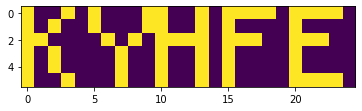

In [40]:
plt.imshow(imagekeeper, interpolation='nearest')
plt.show()

#### Day 9

In [41]:
# class IntCode_v3:
#     def __init__(self, intcode):
#         self.intcode = intcode
#         self.reset()
    
#     def reset(self):
# #         self.work_intcode = self.intcode[:]
#         self.work_intcode = {idx:val for idx, val in enumerate(self.intcode)} 
#         self.output = []
#         self.mem = {}
        
#     @classmethod
#     def load(cls, filename):
#         with open(filename, 'r') as file:
#             return cls([int(x) for x in file.read().split(',')])
    
#     @classmethod
#     def test_txt(cls, text, calc, **input_dict):
#         test_intcode = cls([int(x) for x in text.split(',')])
#         test_intcode.intcodeRead(calc, outmode = 0, **input_dict)
    
#     def mode_manage(self, num, mode):
#         if mode == 0:
#             return self.work_intcode.get(num, 0)
#         elif mode == 1:
#             return num
#         elif mode == 2:
#             return self.work_intcode.get(self.mem['relbase'] + num, 0)
    
#     def spec_mode_manage(self, num, mode):
#         if mode == 0 or mode == 1:
#             return num
#         elif mode == 2:
#             return self.mem['relbase'] + num
                
#     def instr_manage(self, selfmem):      
#         current_idx =  selfmem['current_idx']
        
#         instr_str = str(self.work_intcode.get(current_idx, 0))
#         params = {x:int(y) for x, y in enumerate(reversed(instr_str[:len(instr_str)-2]))}
#         opcode = instr_str[len(instr_str)-2:]
        
        
# #         print(instr_str, opcode)
#         if int(opcode) == 1:
#             param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
#             param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
#             self.work_intcode[output_loc] = param_a + param_b
            
#             current_idx += 4
            
#         elif int(opcode) == 2:
#             param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
#             param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
#             self.work_intcode[output_loc] = param_a * param_b
            
#             current_idx += 4

#         elif int(opcode) == 3: 
#             try:
#                 move_num = self.spec_mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))            
#                 self.work_intcode[move_num] = selfmem['inputs'][selfmem['input_idx']]
#                 selfmem['input_idx'] += 1
            
#                 current_idx += 2
#             except IndexError:
#                 print('HALT COMMAND')
#                 selfmem['midhalt'] = 1
        
#         elif int(opcode) == 4:
#             val_output = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
#             self.output.append(val_output)
            
#             current_idx += 2
        
#         elif int(opcode) == 5:
#             check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
#             if check != 0:
#                 current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             else:
#                 current_idx += 3
        
#         elif int(opcode) == 6:
#             check = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
#             if check == 0:
#                 current_idx = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             else:
#                 current_idx += 3
        
#         elif int(opcode) == 7:
#             param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
#             param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
#             if param_a < param_b:
#                 self.work_intcode[output_loc] = 1
#             else:
#                 self.work_intcode[output_loc] = 0
            
#             current_idx += 4
        
#         elif int(opcode) == 8:
#             param_a = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
#             param_b = self.mode_manage(self.work_intcode.get(current_idx + 2, 0), params.get(1, 0))
#             output_loc = self.spec_mode_manage(self.work_intcode.get(current_idx + 3, 0), params.get(2, 0))
            
#             if param_a == param_b:
#                 self.work_intcode[output_loc] = 1
#             else:
#                 self.work_intcode[output_loc] = 0
                
#             current_idx += 4
        
#         elif int(opcode) == 9:
#             rel_adj = self.mode_manage(self.work_intcode.get(current_idx + 1, 0), params.get(0, 0))
            
#             selfmem['relbase'] += rel_adj
                
#             current_idx += 2
        
#         return current_idx
       
#     def intcodeRead(self, calc, outmode = 1, **input_dict):
#         current_idx = 0
        
#         if self.mem == {}:
#             self.mem = input_dict
#             self.mem['input_idx'] = 0
#             self.mem['midhalt'] = None
#             self.mem['current_idx'] = 0
#             self.mem['relbase'] = 0
            
#             if isinstance(self.mem.get('inputs',0), int):
#                 self.mem['inputs'] = [self.mem.get('inputs',0)]
#         else:
#             self.mem['inputs'] = input_dict['inputs']
#             self.mem['midhalt'] = 0
# #         print(self.output)
             
#         if calc == 'nv':
#             print(
#                 f'Calculating using NOUN/VERB method\n' 
#                 f'Noun: {nv.get("noun", 0)}\n' 
#                 f'Verb: {nv.get("verb", 0)}\n' 
#                 f"Note: If noun or verb used in inputs are > 99, noun and verb default to intcode's default values"
#             )
#             self.work_intcode[1] = self.mem.get('noun', x[1])
#             self.work_intcode[2] = self.mem.get('verb', x[2])
            
#         elif calc == 'input':
#             print(
# #                 f'Calculating using input method\n'
# #                 f'Note: Default value if "val" variable not in parameters is 0'
#             )
        
#         while self.work_intcode.get(self.mem['current_idx'], 0) != 99 and self.mem['midhalt'] != 1:
# #             print(self.mem['current_idx'])
#             self.mem['current_idx'] = self.instr_manage(self.mem)

#         reconstituted = [self.work_intcode.get(x, 0) for x in range(max(self.work_intcode)+1)]
        
#         if outmode == 1:
#             return reconstituted, self.output
#         elif outmode == 'output_only':
#             return self.output
#         elif outmode == 'last_out':
#             return self.output[-1]
#         else:
#             print(reconstituted, self.output, self.mem.get('inputs'))

In [42]:
boost_run = IntCode_v3.load('day09.txt')

In [43]:
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 1)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 0, 2204990589, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64,

In [44]:
boost_run.reset()
boost_run.intcodeRead(calc = 'input', outmode = 0, inputs = 2)


[1102, 34463338, 34463338, 63, 1007, 63, 34463338, 63, 1005, 63, 53, 1102, 3, 1, 1000, 109, 988, 209, 12, 9, 1000, 209, 6, 209, 3, 203, 0, 1008, 1000, 1, 63, 1005, 63, 65, 1008, 1000, 2, 63, 1005, 63, 904, 1008, 1000, 0, 63, 1005, 63, 58, 4, 25, 104, 0, 99, 4, 0, 104, 0, 99, 4, 17, 104, 0, 99, 1, 0, 1101, 0, 31, 1019, 1101, 25, 0, 1008, 1102, 35, 1, 1009, 1102, 422, 1, 1029, 1102, 1, 21, 1005, 1102, 1, 734, 1027, 1102, 29, 1, 1000, 1101, 32, 0, 1018, 1102, 28, 1, 1016, 1101, 0, 38, 1015, 1101, 0, 378, 1023, 1101, 30, 0, 1017, 1102, 1, 381, 1022, 1101, 0, 37, 1006, 1102, 1, 1, 1021, 1101, 0, 24, 1011, 1102, 1, 23, 1002, 1101, 0, 0, 1020, 1101, 0, 20, 1007, 1101, 427, 0, 1028, 1101, 26, 0, 1014, 1101, 27, 0, 1010, 1101, 0, 39, 1001, 1101, 34, 0, 1012, 1102, 1, 36, 1013, 1101, 0, 33, 1003, 1101, 804, 0, 1025, 1101, 737, 0, 1026, 1102, 1, 809, 1024, 1102, 1, 22, 1004, 109, 9, 1201, -7, 0, 63, 1008, 63, 20, 63, 1005, 63, 205, 1001, 64, 1, 64, 1106, 0, 207, 4, 187, 1002, 64, 2, 64, 109, 2, 

#### Day 10

##### Part 1

In [45]:
with open('day10.txt', 'r') as file:
#     print(file.readlines())
    asteroid_alias = {}
    refval = 0
    for y, row in enumerate(file.readlines()):
        for x, symbol in enumerate(row.strip()):
            if symbol == '#':
                asteroid_alias[refval] = (x,y)
                refval += 1

In [46]:
def calculate_distance(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
  
    distance = np.linalg.norm(np.array(ast1) - np.array(ast2))
    
    return distance
    
def calculate_angle(ast1, ast2):
    ast1 = np.array(ast1) 
    ast2 = np.array(ast2)
    # Convert coordinate sytem from top left (0,0), to asteroid B in relative position to asteroid A (0,0)
    astB_coord = (ast2 - ast1) * [1, -1] # converts y-coordinate

    #calculate degrees based on coordinate of 2nd point
    angle = np.degrees(np.arctan2(*astB_coord))
    
    return angle

In [47]:
# for each asteroid (alias), check all asteroids, keep a dict of angles:distance, and change when a lower distance is found for an angle
ast_output = {alias:{} for alias in asteroid_alias.keys()}

for x, origin in asteroid_alias.items():
    for y, target in asteroid_alias.items():
        sight_angle = calculate_angle(origin, target)
        distance = calculate_distance(origin, target)
        
        if (ast_output[x].get(sight_angle, None) == None) or (ast_output[x].get(sight_angle, None) > distance):
            ast_output[x][sight_angle] = distance

In [48]:
best_asteroid_station = sorted(ast_output, key = lambda x: len(ast_output[x].keys()), reverse=True)[0] #Sort by # of keys
los = len(ast_output[289].keys()) # Length of internal dictionary = Number of asteroids visible
print(f'Asteroid {best_asteroid_station}: {los} asteroids in Line of Sight (including itself)')

Asteroid 289: 284 asteroids in Line of Sight (including itself)


##### Part 1

In [49]:
ast289 = asteroid_alias[289]
relative_to_289 = [(alias, calculate_angle(ast289, coord), calculate_distance(ast289, coord))\
                   for alias, coord in asteroid_alias.items() if alias is not 289]

In [50]:
angledict = defaultdict(list)

for ast in relative_to_289:
    angle = ast[1]
    
    if angle < 0:
        angle = angle + 360

    angledict[angle].append((ast[0], ast[2]))
    angledict[angle] = sorted(angledict[angle], key=lambda x: x[1], reverse=False)
    
range_targets = sorted(angledict.keys())

In [51]:
range_idx = 0
destroyed = 0
target_list = deepcopy(angledict)

for val in range(len(relative_to_289)):
    true_idx = range_idx % len(range_targets)
    current_traj = range_targets[true_idx]
    
    try:
        shot = target_list[current_traj]
        print(f'Destroy count: {destroyed + 1} | Asteroid {shot[0]} destroyed, location {asteroid_alias[shot[0][0]]}, angle {current_traj}')
        shot.pop(0)
        
        destroyed += 1
        range_idx += 1
    
    except IndexError:
        print(f'No more asteroids in angle {current_traj}')
        range_idx += 1
        
        continue  

Destroy count: 1 | Asteroid (289, 0.0) destroyed, location (20, 19), angle 0.0
Destroy count: 2 | Asteroid (12, 19.026297590440446) destroyed, location (21, 0), angle 3.0127875041833403
Destroy count: 3 | Asteroid (56, 16.0312195418814) destroyed, location (21, 3), angle 3.576334374997351
Destroy count: 4 | Asteroid (69, 15.033296378372908) destroyed, location (21, 4), angle 3.8140748342903543
Destroy count: 5 | Asteroid (113, 12.041594578792296) destroyed, location (21, 7), angle 4.763641690726178
Destroy count: 6 | Asteroid (13, 19.1049731745428) destroyed, location (22, 0), angle 6.009005957494525
Destroy count: 7 | Asteroid (153, 9.055385138137417) destroyed, location (21, 10), angle 6.34019174590991
Destroy count: 8 | Asteroid (166, 8.06225774829855) destroyed, location (21, 11), angle 7.125016348901798
Destroy count: 9 | Asteroid (187, 7.0710678118654755) destroyed, location (21, 12), angle 8.13010235415598
Destroy count: 10 | Asteroid (99, 13.152946437965905) destroyed, location

In [52]:
# 200th destroyed asteroid: Alias 60, poistion (4,4)
# Answer is X * 100 + Y = 404

#### Day 11

##### Part 1

In [53]:
class paintBot():
    def __init__(self, int_filename, initposition = [0.,0.]):
        self.direction_ref  = {0: (np.array([0.,1.]), 'up'), 1: (np.array([1.,0.]), 'right'),\
                               2: (np.array([0.,-1.]), 'down'), 3: (np.array([-1.,0.]), 'left')}
        # Keys refer to current face, 0 (up) going in clockwise direction to 3 (left)
        # Values refer to movement method when facing that direction
        
        self.ICprocessor = IntCode_v3.load(int_filename)
        self.reset(initposition)
    
    def reset(self, initposition = [0., 0.]):
        self.ICprocessor.reset()
        
        self.position = np.array(initposition)
        self.face_idx = 0
        self.paintgrid = defaultdict(lambda: 0) # Should keep record of CURRENT canvas status
        self.inss = []
    
    def change_direction(self, dircode):
        idx_mod = np.where(dircode == 0, 1, -1)
        if dircode == 1:
            idx_mod = 1
        elif dircode == 0:
            idx_mod = -1
        
        self.face_idx = (self.face_idx + idx_mod) % 4
    
    def action_step(self):
        input_color = self.paintgrid[self.position.tobytes()]
        # 0 black, 1 white
        # Keys of self.paintgrid will keep memory of how many panels painted at least once
        
        print(f'Position: {self.position}\nFacing {self.direction_ref[self.face_idx][1]}\nCurrent color: {input_color}\n')
        self.inss.append(input_color)
        
        output = self.ICprocessor.intcodeRead(calc='input', outmode = 'output_only', inputs = self.inss)
        output_color = output[-2]
        output_dircode = output[-1]
        
        print(output[-2:])
        
        self.paintgrid[self.position.tobytes()] = output_color
        self.change_direction(output_dircode)
        self.position = self.position + self.direction_ref[self.face_idx][0]
        
       
    def run_paintBot(self, col_1 = 0):
        self.paintgrid[self.position.tobytes()] = col_1
        
        while self.ICprocessor.mem.get('midhalt', 1) == 1:
            self.action_step()    
    

In [54]:
pb = paintBot('day11.txt')

In [55]:
pb.reset()
pb.run_paintBot(col_1 = 0) # bot's starting position color is black (0)

Position: [0. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  0.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [0. 1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [0. 2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [-2.  2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]

[1, 0]
Position: [-5. -3.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-4. -3.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [-4. -2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-5. -2.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [-5. -1.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-6. -1.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-6. -2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-5. -2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-5. -3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [-6. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [-6. -2.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-7. -2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-7. -3.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [-8. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Pos



HALT COMMAND
[0, 0]
Position: [-3.  2.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [-3.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [-2.  3.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [-2.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [-1.  1.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [-2.  1.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  0.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [-1.  0.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [-1.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [-2.  1.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [-2.  2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [-3.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [-3.  1.]
Facing down
Current color: 0


HALT CO

[1, 0]
Position: [6. 1.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [6. 2.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 2.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [7. 3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 3.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 2.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 2.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 1.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 1.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 0.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 0.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [7. 1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [8. 1.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 2.]
Facing left
C



HALT COMMAND
[0, 0]
Position: [8. 7.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [8. 8.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [7. 8.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [7. 7.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 7.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [8. 8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 8.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [7. 7.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [6. 7.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [6. 8.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [5. 8.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [5. 9.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [6. 9.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [ 6. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 7. 10

[0, 0]
Position: [10. 10.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [ 9. 10.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [9. 9.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [10.  9.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [10. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [11. 10.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [11. 11.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [12. 11.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [12. 12.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. 12.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [13. 13.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [14. 13.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [14. 12.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. 12.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Posi

[1, 1]
Position: [18.  2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [19.  2.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [19.  3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [20.  3.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [20.  4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [21.  4.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [21.  5.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [20.  5.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [20.  4.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [19.  4.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [19.  3.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [18.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [18.  4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [19.  4.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Pos

[0, 1]
Position: [11.  9.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [10.  9.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [10.  8.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [11.  8.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [11.  7.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [12.  7.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [12.  8.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [13.  8.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [13.  7.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [12.  7.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [12.  6.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [13.  6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [13.  7.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [14.  7.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]


Position: [13.  9.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [12.  9.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [12.  8.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [11.  8.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [11.  9.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [10.  9.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [10. 10.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [11. 10.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [11. 11.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [12. 11.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [12. 10.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [13. 10.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [13.  9.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [14.  9.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: 

Position: [16.  1.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [16.  0.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [17.  0.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [17.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [18.  1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [18.  2.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [17.  2.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [17.  1.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [18.  1.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [18.  0.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [19.  0.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. -1.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [18. -1.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [18. -2.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Positi

[0, 0]
Position: [17. -6.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [17. -5.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. -5.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [16. -4.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -4.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. -3.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [14. -3.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [14. -4.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -4.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. -3.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [14. -3.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [14. -4.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [15. -4.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [15. -3.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Positi

Position: [23. 11.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 11.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 10.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 10.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 11.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 11.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 12.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 12.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 13.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 13.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [26. 14.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 14.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 15.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [26. 15.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [



HALT COMMAND
[1, 0]
Position: [14. 20.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. 20.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [13. 21.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [14. 21.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [14. 22.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. 22.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [15. 23.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 22.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [15. 22.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [15. 21.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 21.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 20.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. 20.]
Facing right
Current color: 0


HALT 



HALT COMMAND
[1, 0]
Position: [38. 22.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [37. 22.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [37. 21.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 21.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [36. 20.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 20.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 21.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [34. 21.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 22.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [33. 22.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [33. 23.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [34. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [34. 24.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [33. 24.]
Facing left
Current color: 1


HALT COMMAND


[1, 1]
Position: [48. 20.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 17.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 16.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [53. 16.]
Facing right
Current color: 0


HALT COMMAND
[1



HALT COMMAND
[1, 1]
Position: [37. 16.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 17.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [36. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [37. 17.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [37. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [37. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [36. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [36. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. 16.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [35. 15.]
Facing down
Current color: 1


HALT COM

HALT COMMAND
[1, 0]
Position: [40.  4.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [41.  4.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [41.  3.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [40.  3.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [40.  4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [41.  4.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [41.  3.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [42.  3.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [42.  2.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [43.  2.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [43.  1.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [44.  1.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [44.  0.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [43.  0.]
Facing left
Current color: 0


HALT 



HALT COMMAND
[1, 1]
Position: [49. -5.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. -5.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [48. -6.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. -6.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. -7.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [48. -7.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [48. -8.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [49. -8.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. -9.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [48. -9.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [48. -8.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [47. -8.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [47. -9.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [46. -9.]
Facing left
Current color: 0


HALT C



HALT COMMAND
[1, 1]
Position: [36. -4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. -4.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [37. -3.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. -3.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. -2.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. -2.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. -1.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. -1.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [38.  0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [39.  0.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [39.  1.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40.  1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [40.  2.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [41.  2.]
Facing right
Current color: 1


HALT COMMAND

Position: [57. 20.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 19.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [56. 19.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [56. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [55. 18.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [55. 19.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [54. 19.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [54. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [53. 18.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 16.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [53. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position

[0, 0]
Position: [58. 22.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [57. 22.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [57. 23.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [58. 23.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [58. 24.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [59. 24.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [59. 25.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [58. 25.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [58. 26.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [57. 26.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [57. 25.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [58. 25.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [58. 24.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [57. 24.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Posi

[0, 0]
Position: [50. 24.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 24.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 23.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 23.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 22.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [49. 22.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [49. 23.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 23.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 22.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 22.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 23.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 23.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 24.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 24.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Po



HALT COMMAND
[0, 0]
Position: [51. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 27.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 27.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [52. 26.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 26.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [53. 27.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 27.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [52. 26.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 26.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 27.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 27.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 28.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 27.]
Facing down
Current color: 1


HALT CO

HALT COMMAND
[1, 0]
Position: [39. 33.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 33.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [40. 32.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 33.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 33.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 34.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 34.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 35.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 35.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 36.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [39. 36.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [39. 37.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 37.]
Facing right
Current color: 0


HALT COMMAND



HALT COMMAND
[1, 0]
Position: [43. 37.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 37.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 36.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 36.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 35.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 35.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 36.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [41. 36.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 37.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 37.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [40. 36.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 36.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [39. 37.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 37.]
Facing left
Current color: 0


HALT COMMAN

[1, 0]
Position: [24. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [24. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 29.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 28.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 27.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 27.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 28.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 29.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [26. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
P

[0, 0]
Position: [20. 31.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 30.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 30.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 29.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [18. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [17. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 29.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [17. 28.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [17. 29.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [16. 29.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [16. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
P



HALT COMMAND
[1, 1]
Position: [22. 41.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 40.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [23. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 38.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [25. 38.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 39.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 40.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 41.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 41.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 42.]
Facing up
Current color: 0


HALT CO

HALT COMMAND
[0, 0]
Position: [28. 49.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 50.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 50.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 49.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 49.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 50.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [27. 50.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 51.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 51.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 52.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [25. 52.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 53.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 53.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [26. 54.]
Facing up
Current color: 0


HALT COMMAND
[1

HALT COMMAND
[1, 1]
Position: [21. 56.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [21. 55.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [22. 55.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [22. 54.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 54.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [23. 55.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [24. 55.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [24. 56.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 56.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [25. 55.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [26. 55.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [26. 54.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [27. 54.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [27. 55.]
Facing up
Current color: 0


HALT 



HALT COMMAND
[1, 1]
Position: [30. 51.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [30. 52.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [31. 52.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [31. 53.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [32. 53.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [32. 54.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [31. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [31. 53.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [30. 53.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [30. 54.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [29. 54.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 53.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 53.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [28. 52.]
Facing down
Current color: 1


HALT COMM

[1, 1]
Position: [40. 44.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 44.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [39. 43.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 43.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [38. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 42.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [37. 43.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [38. 43.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [38. 44.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [37. 44.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 45.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [38. 45.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [38. 44.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [37. 44.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Posit

[0, 1]
Position: [43. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 33.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 33.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [44. 34.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 34.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 33.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 33.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 32.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 32.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [43. 31.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 31.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 32.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [45. 32.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [45. 31.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]


[1, 1]
Position: [53. 44.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [53. 43.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 43.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 44.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 44.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 43.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [52. 43.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 42.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 42.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [51. 43.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [50. 43.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [50. 44.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 44.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [49. 43.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Pos

[1, 0]
Position: [42. 47.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [42. 46.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 46.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 47.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 47.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 46.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [43. 46.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [43. 47.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 47.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [44. 48.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 48.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [45. 47.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [44. 47.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 46.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
P


HALT COMMAND
[1, 1]
Position: [41. 55.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 55.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 56.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 56.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 57.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 57.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [42. 58.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [41. 58.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 59.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [40. 59.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [40. 60.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 60.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [41. 59.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 59.]
Facing right
Current color: 0


HALT COMMAND




HALT COMMAND
[1, 0]
Position: [42. 53.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 52.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 52.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 53.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 53.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [42. 52.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [43. 52.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [43. 51.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [44. 51.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [44. 50.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [43. 50.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [43. 49.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [42. 49.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [42. 50.]
Facing up
Current color: 0


HALT

[1, 0]
Position: [21. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [20. 39.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [20. 40.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. 40.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [19. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [20. 39.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [20. 38.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [19. 38.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [19. 37.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 37.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [18. 38.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [17. 38.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [17. 37.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [16. 37.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Po



HALT COMMAND
[1, 0]
Position: [29. 38.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [29. 39.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]
Position: [28. 39.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 40.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 39.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 39.]
Facing left
Current color: 1


HALT COMMAND
[0, 1]
Position: [28. 40.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [29. 40.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [29. 39.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 39.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [28. 40.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 40.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [29. 39.]
Facing down
Current color: 1


HALT COM

[1, 0]
Position: [52. 28.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 28.]
Facing left
Current color: 0


HALT COMMAND
[1, 1]
Position: [51. 29.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 29.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 30.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 30.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 29.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [54. 29.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [54. 30.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [55. 30.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [55. 29.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [54. 29.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [54. 28.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [55. 28.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]




HALT COMMAND
[1, 1]
Position: [60. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [61. 18.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [61. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [60. 17.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [60. 16.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [61. 16.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [61. 17.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [60. 17.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [60. 16.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [61. 16.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [61. 15.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [62. 15.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [62. 14.]
Facing down
Current color: 0


HALT COMMAND
[1, 1]
Position: [61. 14.]
Facing left
Current color: 0


HA

[1, 1]
Position: [52. 19.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [52. 20.]
Facing up
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 20.]
Facing left
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 19.]
Facing down
Current color: 1


HALT COMMAND
[0, 1]
Position: [50. 19.]
Facing left
Current color: 0


HALT COMMAND
[1, 0]
Position: [50. 18.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [51. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 0]
Position: [51. 19.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 19.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [52. 18.]
Facing down
Current color: 1


HALT COMMAND
[0, 0]
Position: [53. 18.]
Facing right
Current color: 1


HALT COMMAND
[0, 1]
Position: [53. 17.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [54. 17.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [54. 18.]
Facing up
Current color: 0


HALT COMMAND
[1, 0]


In [56]:
len(pb.paintgrid) #paintgrid keeps memory of current board state

2594

##### Part 2

In [57]:
pb.reset()
pb.run_paintBot(col_1 = 1)

Position: [0. 0.]
Facing up
Current color: 1


HALT COMMAND
[0, 1]
Position: [1. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 1. -1.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [ 2. -1.]
Facing right
Current color: 0


HALT COMMAND
[0, 0]
Position: [2. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [3. 0.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [ 3. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 4. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [4. 0.]
Facing up
Current color: 0


HALT COMMAND
[0, 1]
Position: [5. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 5. -1.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [ 6. -1.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [6. 0.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [7. 0.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [ 7. -1.]
Fac

HALT COMMAND
[0, 1]
Position: [29. -4.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [29. -5.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [30. -5.]
Facing right
Current color: 0


HALT COMMAND
[0, 0]
Position: [30. -4.]
Facing up
Current color: 0


HALT COMMAND
[0, 1]
Position: [31. -4.]
Facing right
Current color: 0


HALT COMMAND
[1, 1]
Position: [31. -5.]
Facing down
Current color: 0


HALT COMMAND
[1, 0]
Position: [32. -5.]
Facing right
Current color: 0


HALT COMMAND
[0, 0]
Position: [32. -4.]
Facing up
Current color: 0


HALT COMMAND
[0, 1]
Position: [33. -4.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [33. -5.]
Facing down
Current color: 0


HALT COMMAND
[0, 0]
Position: [34. -5.]
Facing right
Current color: 0


HALT COMMAND
[1, 0]
Position: [34. -4.]
Facing up
Current color: 0


HALT COMMAND
[1, 1]
Position: [35. -4.]
Facing right
Current color: 0


HALT COMMAND
[0, 1]
Position: [35. -5.]
Facing down
Current color: 0


HALT 

In [58]:
paint_x = []
paint_y = []


for tile in pb.paintgrid.keys():
    recovered = np.frombuffer(tile, count=-1)
    paint_x.append(recovered[0])
    paint_y.append(recovered[1])
    
(min(paint_x), max(paint_x), min(paint_y), max(paint_y)) # get canvas dimensions

(0.0, 42.0, -5.0, 0.0)

In [59]:
all_white_tiles = [np.frombuffer(tile, count=-1) + [0., 5.] for tile, col in pb.paintgrid.items() if col == 1]

In [60]:
canvas = np.zeros(shape=(6,43))
for fill in all_white_tiles:
    canvas[int(fill[1])][int(fill[0])] = 1

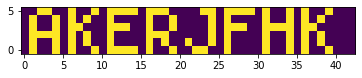

In [61]:
plt.imshow(canvas, interpolation='nearest', origin='lower')
plt.show()

#### Day 12

##### Part 1

In [62]:
def parse_poslines(list_):
    return np.array([[float(num) for num in re.sub(r'[^0-9,-]', '', x).split(',')] for x in list_])

In [63]:
def grav_update(arr1, arr2):
#     print((arr1, arr2, np.where(np.greater(arr1, arr2), -1., 1.)))
    return np.where(np.equal(arr1, arr2), 0., (np.where(np.greater(arr1, arr2), -1., 1.)))

In [64]:
def energy(pos, vel):
    en_list = []
    
    for x in range(len(pos)):
        pot = np.sum(np.abs(pos[x]))
        kin = np.sum(np.abs(vel[x]))
        en_list.append(pot*kin)
#         print(pos[x], pot, vel[x], kin)
    
#     print(en_list)
    return sum(en_list)

In [65]:
def update_step(pos, vel, it):
    
    for pos1, pos2 in itertools.combinations([idx for idx in range(len(pos))], 2):
        arr1 = pos[pos1]
        arr2 = pos[pos2]

        arr1_grav_change = grav_update(arr1, arr2)

        vel[pos1] = vel[pos1] + arr1_grav_change
        vel[pos2] = vel[pos2] - arr1_grav_change
    
    final = np.add(pos, vel)

#     print(f'Step {it+1}')
#     for print1, print2 in zip(final, vel):
#         print(f'{print1}\t\t{print2}')
    
    return final

In [66]:
with open('day12.txt', 'r') as file:
    positions = parse_poslines(file.readlines())

velocity = np.zeros(shape=(4,3))

In [67]:
position_copy = deepcopy(positions)
velocity_copy = deepcopy(velocity)

for it in range(1000):
    position_copy = update_step(position_copy, velocity_copy, it)

print(energy(position_copy, velocity_copy))

9958.0


##### Part 2

In [68]:
cycle_step = defaultdict(lambda: 0)

for idx in range(3):
    print(f'IDX {idx}')
    initial_1dim = np.array([x[idx] for x in positions])
    vel_1dim = np.zeros(shape = (4,))
    
    print(initial_1dim, vel_1dim)

    mem_pos_1dim = []
    mem_val_1dim = []

    while np.array_equal(initial_1dim, mem_pos_1dim) == False:
        if mem_pos_1dim == []:
            mem_pos_1dim = np.copy(initial_1dim)
            mem_val_1dim = np.copy(vel_1dim)
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1
        else:
            mem_pos_1dim = update_step(mem_pos_1dim, mem_val_1dim, cycle_step[idx])
            cycle_step[idx] += 1

IDX 0
[ 7. -2. 12.  5.] [0. 0. 0. 0.]


C:\Anaconda\envs\advent\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


IDX 1
[10.  7.  5. -8.] [0. 0. 0. 0.]
IDX 2
[17.  0. 12.  6.] [0. 0. 0. 0.]


In [69]:
cycle_step

defaultdict(<function __main__.<lambda>()>, {0: 28481, 1: 231613, 2: 193051})

In [70]:
np.lcm.reduce(np.array([x+1 for x in cycle_step.values()], dtype='int64'))

318382803780324

#### Day 13

##### Part 1

In [71]:
arcade = IntCode_v3.load('day13.txt')

In [72]:
screen = arcade.intcodeRead(calc='input', outmode = 'output_only')

In [73]:
output_screen = {(screen[idx], screen[idx+1]): screen[idx+2] for idx in range(0, len(screen), 3)}
Counter(output_screen.values())

Counter({1: 89, 0: 615, 2: 329, 4: 1, 3: 1})

In [74]:
status_ = defaultdict(list)
for idx in range(0, len(screen), 3):
    status_[screen[idx+2]].append((screen[idx], screen[idx+1]))

In [75]:
output_screen

{(0, 0): 1,
 (1, 0): 1,
 (2, 0): 1,
 (3, 0): 1,
 (4, 0): 1,
 (5, 0): 1,
 (6, 0): 1,
 (7, 0): 1,
 (8, 0): 1,
 (9, 0): 1,
 (10, 0): 1,
 (11, 0): 1,
 (12, 0): 1,
 (13, 0): 1,
 (14, 0): 1,
 (15, 0): 1,
 (16, 0): 1,
 (17, 0): 1,
 (18, 0): 1,
 (19, 0): 1,
 (20, 0): 1,
 (21, 0): 1,
 (22, 0): 1,
 (23, 0): 1,
 (24, 0): 1,
 (25, 0): 1,
 (26, 0): 1,
 (27, 0): 1,
 (28, 0): 1,
 (29, 0): 1,
 (30, 0): 1,
 (31, 0): 1,
 (32, 0): 1,
 (33, 0): 1,
 (34, 0): 1,
 (35, 0): 1,
 (36, 0): 1,
 (37, 0): 1,
 (38, 0): 1,
 (39, 0): 1,
 (40, 0): 1,
 (41, 0): 1,
 (42, 0): 1,
 (43, 0): 1,
 (44, 0): 1,
 (0, 1): 1,
 (1, 1): 0,
 (2, 1): 0,
 (3, 1): 0,
 (4, 1): 0,
 (5, 1): 0,
 (6, 1): 0,
 (7, 1): 0,
 (8, 1): 0,
 (9, 1): 0,
 (10, 1): 0,
 (11, 1): 0,
 (12, 1): 0,
 (13, 1): 0,
 (14, 1): 0,
 (15, 1): 0,
 (16, 1): 0,
 (17, 1): 0,
 (18, 1): 0,
 (19, 1): 0,
 (20, 1): 0,
 (21, 1): 0,
 (22, 1): 0,
 (23, 1): 0,
 (24, 1): 0,
 (25, 1): 0,
 (26, 1): 0,
 (27, 1): 0,
 (28, 1): 0,
 (29, 1): 0,
 (30, 1): 0,
 (31, 1): 0,
 (32, 1): 0,
 (33, 

In [76]:
status_

defaultdict(list,
            {1: [(0, 0),
              (1, 0),
              (2, 0),
              (3, 0),
              (4, 0),
              (5, 0),
              (6, 0),
              (7, 0),
              (8, 0),
              (9, 0),
              (10, 0),
              (11, 0),
              (12, 0),
              (13, 0),
              (14, 0),
              (15, 0),
              (16, 0),
              (17, 0),
              (18, 0),
              (19, 0),
              (20, 0),
              (21, 0),
              (22, 0),
              (23, 0),
              (24, 0),
              (25, 0),
              (26, 0),
              (27, 0),
              (28, 0),
              (29, 0),
              (30, 0),
              (31, 0),
              (32, 0),
              (33, 0),
              (34, 0),
              (35, 0),
              (36, 0),
              (37, 0),
              (38, 0),
              (39, 0),
              (40, 0),
              (41, 0),
              (42, 0),


In [77]:
{x: len(status_[x]) for x in status_}

{1: 89, 0: 615, 2: 329, 4: 1, 3: 1}

##### Part 2

In [78]:
arcade = IntCode_v3.load('day13.txt')
arcade.work_intcode[0] = 2

joystick_seq = []
status = {}
intersect = 0

while intersect != 329:
    current_screen = arcade.intcodeRead(calc='input', outmode = 'output_only', inputs = joystick_seq[:])
    
#     print(arcade.mem)
    
    status = defaultdict(list)
    for idx in range(0, len(current_screen), 3):
        if (current_screen[idx], current_screen[idx+1]) == (-1,0):
            status['score'] = current_screen[idx+2]
        else:
            status[current_screen[idx+2]].append((current_screen[idx], current_screen[idx+1]))   
    # add block monitoring dict (coord): status
    
    intersect = len((set(status[2])).intersection(set(status[0]))) 
    
    ball = status[4][-1]
    paddle = status[3][-1]
    
#     print(f'Ball: {ball}, Paddle: {paddle}')
    
    print(f'Score: {status.get("score", 0)}')
    print(f'{intersect} tiles hit!')
    
    new_input = int(np.where(paddle[0] == ball[0], 0, np.where(paddle[0] > ball[0], -1, 1)))
    # input method: Chase
    # ball delta right, paddle rel left 2b, move right
    # ball delta left, paddle rel right 2b, move left
    # ball delta left, paddle rel lef 2b
    
    joystick_seq.append(new_input)
    
#     print(joystick_seq)
print(f'FINISHED: SCORE = {status.get("score", 0)}')


HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 0
0 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 64
1 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 68
2 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 117
3 tiles hit!

HALT COMMAND
Score: 246
5 tiles hit!

HALT COMMAND
Score: 246
5 tiles hit

Score: 2080
40 tiles hit!

HALT COMMAND
Score: 2080
40 tiles hit!

HALT COMMAND
Score: 2080
40 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2173
41 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2253
42 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND
Score: 2275
43 tiles hit!

HALT COMMAND


Score: 3902
73 tiles hit!

HALT COMMAND
Score: 3902
73 tiles hit!

HALT COMMAND
Score: 3902
73 tiles hit!

HALT COMMAND
Score: 3902
73 tiles hit!

HALT COMMAND
Score: 3902
73 tiles hit!

HALT COMMAND
Score: 4014
76 tiles hit!

HALT COMMAND
Score: 4059
78 tiles hit!

HALT COMMAND
Score: 4059
78 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4112
79 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4185
80 tiles hit!

HALT COMMAND
Score: 4249
81 tiles hit!

HALT COMMAND


Score: 4938
100 tiles hit!

HALT COMMAND
Score: 4938
100 tiles hit!

HALT COMMAND
Score: 4938
100 tiles hit!

HALT COMMAND
Score: 4938
100 tiles hit!

HALT COMMAND
Score: 4938
100 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4944
101 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 tiles hit!

HALT COMMAND
Score: 4992
102 

Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7714
158 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 tiles hit!

HALT COMMAND
Score: 7723
159 

Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8432
173 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 tiles hit!

HALT COMMAND
Score: 8453
174 

Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 tiles hit!

HALT COMMAND
Score: 8999
188 

Score: 9757
206 tiles hit!

HALT COMMAND
Score: 9757
206 tiles hit!

HALT COMMAND
Score: 9757
206 tiles hit!

HALT COMMAND
Score: 9757
206 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9793
207 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9850
208 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 tiles hit!

HALT COMMAND
Score: 9859
209 

Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11519
243 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT COMMAND
Score: 11593
244 tiles hit!

HALT 

Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12082
256 tiles hit!

HALT COMMAND
Score: 12135
257 tiles hit!

HALT 

Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12674
267 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT COMMAND
Score: 12738
268 tiles hit!

HALT 

Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13000
272 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT COMMAND
Score: 13097
273 tiles hit!

HALT 

Score: 13420
282 tiles hit!

HALT COMMAND
Score: 13420
282 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT COMMAND
Score: 13517
283 tiles hit!

HALT 

Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT COMMAND
Score: 13918
293 tiles hit!

HALT 

Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT COMMAND
Score: 13996
295 tiles hit!

HALT 

Score: 14529
304 tiles hit!

HALT COMMAND
Score: 14529
304 tiles hit!

HALT COMMAND
Score: 14529
304 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT COMMAND
Score: 14578
305 tiles hit!

HALT 

Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT COMMAND
Score: 14790
309 tiles hit!

HALT 

Score: 15002
312 tiles hit!

HALT COMMAND
Score: 15002
312 tiles hit!

HALT COMMAND
Score: 15002
312 tiles hit!

HALT COMMAND
Score: 15039
313 tiles hit!

HALT COMMAND
Score: 15039
313 tiles hit!

HALT COMMAND
Score: 15039
313 tiles hit!

HALT COMMAND
Score: 15039
313 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT COMMAND
Score: 15127
314 tiles hit!

HALT 

Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT COMMAND
Score: 15170
315 tiles hit!

HALT 

Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT COMMAND
Score: 15316
319 tiles hit!

HALT 

Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15439
321 tiles hit!

HALT COMMAND
Score: 15505
322 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT COMMAND
Score: 15530
323 tiles hit!

HALT 

Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15627
324 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT 

Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT COMMAND
Score: 15722
325 tiles hit!

HALT 

Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT COMMAND
Score: 15789
326 tiles hit!

HALT 

Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT 

Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT COMMAND
Score: 15829
327 tiles hit!

HALT 

Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT 

Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT COMMAND
Score: 15927
328 tiles hit!

HALT 

#### Day 14

##### Part 1

In [79]:
prod_queue = defaultdict(lambda: 0)
act_prod = defaultdict(lambda: 0)
formulas = {}

prod_queue['FUEL'] = 1

In [80]:
with open('day14.txt', 'r') as file:
    for x in file.readlines():
        broken = [x.strip() for x in x.split('=>')]
        
        product = broken[-1].split(' ')
        formulas[product[1]] = {'base_amt': int(product[0]), 'call': 0,\
                                'components': {mat.split(' ')[1] : int(mat.split(' ')[0]) for mat\
                                                in [x.strip() for x in broken[0].split(',')]}}

In [81]:
while 0 != 1:
    flag = 1
    update = defaultdict(lambda: 0)
     
    for fg in [key for key, val in prod_queue.items() if val != 0 and key != 'ORE']:
        must_gen = prod_queue[fg]

        base_prod = formulas[fg]['base_amt']
        cur_call = formulas[fg]['call']
        current_prod = base_prod * cur_call
        
        if current_prod >= must_gen:
            flag += 1
            pass
        else:
            new_prod = must_gen - current_prod
            new_call = math.ceil(new_prod/base_prod)
            
            for component, prod_v in formulas[fg]['components'].items():
                update[component] += new_call * prod_v
            formulas[fg]['call'] += new_call
    
    for fg, val in update.items():
        prod_queue[fg] += val
    
    if flag >= len(prod_queue):
        break

In [82]:
prod_queue['ORE']

843220

##### Part 2

In [83]:
prod_queue2 = defaultdict(lambda: 0)
act_prod2 = defaultdict(lambda: 0)
formulas2 = {}

prod_queue2['FUEL'] = 2000000

In [84]:
with open('day14.txt', 'r') as file:
    for x in file.readlines():
        broken = [x.strip() for x in x.split('=>')]
        
        product = broken[-1].split(' ')
        formulas2[product[1]] = {'base_amt': int(product[0]), 'call': 0,\
                                'components': {mat.split(' ')[1] : int(mat.split(' ')[0]) for mat\
                                                in [x.strip() for x in broken[0].split(',')]}}

In [85]:
while prod_queue2['ORE'] <= 1000000000000:
    flag = 1
    update = defaultdict(lambda: 0)
     
    for fg in [key for key, val in prod_queue2.items() if val != 0 and key != 'ORE']:
        must_gen = prod_queue2[fg]

        base_prod = formulas2[fg]['base_amt']
        cur_call = formulas2[fg]['call']
        current_prod = base_prod * cur_call
        
        if current_prod >= must_gen:
            flag += 1
            pass
        else:
            new_prod = must_gen - current_prod
            new_call = math.ceil(new_prod/base_prod)
            
            for component, prod_v in formulas2[fg]['components'].items():
                update[component] += new_call * prod_v
            formulas2[fg]['call'] += new_call
    
    for fg, val in update.items():
        prod_queue2[fg] += val
        
    if flag >= len(prod_queue2) and prod_queue2['ORE'] >= 1000000000000:
        print(f'FUEL produced: {prod_queue2["FUEL"] - 1}')
        break
    elif flag >= len(prod_queue2):
        if prod_queue2['FUEL'] % 10000 == 0: 
            print(prod_queue2['FUEL'], prod_queue2['ORE'])
        
        prod_queue2['FUEL'] += 1

2000000 921855873581
2010000 926465326122
2020000 931074795858
2030000 935683740012
2040000 940293047739
2050000 944902510909
2060000 949511952686
2070000 954120908771
2080000 958730242772
2090000 963339686393
2100000 967948619321
2110000 972558082780
2120000 977167397079
2130000 981776844286
2140000 986385817190
2150000 990995247562
2160000 995604566838


In [86]:
prod_queue2["FUEL"] - 1

2169535

#### Day 15

##### Part 1

In [101]:
mapper = IntCode_v3.load('day15.txt')

In [102]:
mapper.reset()

coord_tracker = np.array([0,0])
dir_mover = {1:(0, 1), 2:(0, -1), 3:(-1, 0), 4:(1, 0)}
input_commands = []
record = {}
traverse = [(0,0)]
locator = None

while locator == None:
    pos_paths = []
    
    # Check around current tile, if I can move there and I've never directly chosen to go there, keep
    # Also check if we found it
    for x in range(1,5):
        mapper.reset()
        input_roundtile = input_commands + [x]
        
        output = mapper.intcodeRead(outmode = 'last_out', calc = 'input', inputs = input_roundtile)
        tile = np.array(dir_mover[x]) + coord_tracker
        
        if output == 2:
            print(f'FOUND AT {tile}')
            locator = x
            break
        
        elif output == 1 and tuple(tile) not in traverse:
            pos_paths.append((tile, x))
        
        record[tuple(tile)] = output
    
    if len(pos_paths) != 0 and locator == None:
        path = random.choice(pos_paths)
        
        coord_tracker = path[0]
        input_commands.append(path[1])
        
        traverse.append(tuple(coord_tracker))
        
        print(coord_tracker, input_commands[-4:])
    
    elif locator:
        coord_tracker = coord_tracker + np.array(dir_mover[locator])
        input_commands.append(locator)
        print(f'DESTINATION: {coord_tracker}')
        print(len(input_commands))
        
    else:
        coord_tracker = coord_tracker - np.array(dir_mover[input_commands[-1]])
        input_commands = input_commands[:-1]
        
        print('BB', coord_tracker, input_commands[-4:])





[-1  0] [3]




[-2  0] [3, 3]




[-2  1] [3, 3, 1]




[-2  2] [3, 3, 1, 1]




[-1  2] [3, 1, 1, 4]




[0 2] [1, 1, 4, 4]




[0 3] [1, 4, 4, 1]




[0 4] [4, 4, 1, 1]




[0 5] [4, 1, 1, 1]




[0 6] [1, 1, 1, 1]




[0 7] [1, 1, 1, 1]




[0 8] [1, 1, 1, 1]




[0 9] [1, 1, 1, 1]




[ 0 10] [1, 1, 1, 1]




[ 0 11] [1, 1, 1, 1]




[ 0 12] [1, 1, 1, 1]




[ 0 13] [1, 1, 1, 1]




[ 0 14] [1, 1, 1, 1]




[ 1 14] [1, 1, 1, 4]




[ 2 14] [1, 1, 4, 4]




[ 2 15] [1, 4, 4, 1]




[ 2 16] [4, 4, 1, 1]




[ 2 17] [4, 1, 1, 1]




[ 2 18] [1, 1, 1, 1]




[ 1 18] [1, 1, 1, 3]




[ 0 18] [1, 1, 3, 3]




[ 0 17] [1, 3, 3, 2]




[ 0 16] [3, 3, 2, 2]




[-1 16] [3, 2, 2, 3]




[-2 16] [2, 2, 3, 3]




[-2 17] [2, 3, 3, 1]




[-2 18] [3, 3, 1, 1]




[-3 18] [3, 1, 1, 3]




[-4 18] [1, 1, 3, 3]




[-4 19] [1, 3, 3, 1]




[-4 20] [3, 3, 1, 1]




[-3 20] [3, 1, 1, 4]




[-2 20] [1, 1, 4, 4]




[-1 20] [1, 4, 4, 4]




[ 0 20] [4, 4, 4, 4]




[ 1 20] [4, 4, 4, 4]




[ 2 2




[11  0] [2, 2, 2, 4]




[12  0] [2, 2, 4, 4]




[12  1] [2, 4, 4, 1]




[12  2] [4, 4, 1, 1]




[12  3] [4, 1, 1, 1]




[12  4] [1, 1, 1, 1]




[12  5] [1, 1, 1, 1]




[12  6] [1, 1, 1, 1]




[12  7] [1, 1, 1, 1]




[12  8] [1, 1, 1, 1]




[11  8] [1, 1, 1, 3]




[10  8] [1, 1, 3, 3]




[10  9] [1, 3, 3, 1]




[10 10] [3, 3, 1, 1]




[ 9 10] [3, 1, 1, 3]




[ 8 10] [1, 1, 3, 3]




[8 9] [1, 3, 3, 2]




[8 8] [3, 3, 2, 2]




BB [8 9] [1, 3, 3, 2]




BB [ 8 10] [1, 1, 3, 3]




[ 8 11] [1, 3, 3, 1]




[ 8 12] [3, 3, 1, 1]




[ 9 12] [3, 1, 1, 4]




[10 12] [1, 1, 4, 4]




[11 12] [1, 4, 4, 4]




[12 12] [4, 4, 4, 4]




[12 11] [4, 4, 4, 2]




[12 10] [4, 4, 2, 2]




[13 10] [4, 2, 2, 4]




[14 10] [2, 2, 4, 4]




[14  9] [2, 4, 4, 2]




[14  8] [4, 4, 2, 2]




[15  8] [4, 2, 2, 4]




[16  8] [2, 2, 4, 4]




[16  7] [2, 4, 4, 2]




[16  6] [4, 4, 2, 2]




[16  5] [4, 2, 2, 2]




[16  4] [2, 2, 2, 2]




[15  4] [2, 2, 2, 3]




[14  4] [2, 2, 3, 3]



BB [ 17 -10] [4, 1, 1, 3]




BB [ 18 -10] [4, 4, 1, 1]




BB [ 18 -11] [1, 4, 4, 1]




BB [ 18 -12] [1, 1, 4, 4]




[ 18 -13] [1, 4, 4, 2]




[ 18 -14] [4, 4, 2, 2]




[ 18 -15] [4, 2, 2, 2]




[ 18 -16] [2, 2, 2, 2]




[ 18 -17] [2, 2, 2, 2]




[ 18 -18] [2, 2, 2, 2]




[ 17 -18] [2, 2, 2, 3]




[ 16 -18] [2, 2, 3, 3]




[ 16 -17] [2, 3, 3, 1]




[ 16 -16] [3, 3, 1, 1]




[ 15 -16] [3, 1, 1, 3]




[ 14 -16] [1, 1, 3, 3]




[ 13 -16] [1, 3, 3, 3]




[ 12 -16] [3, 3, 3, 3]




[ 12 -17] [3, 3, 3, 2]




[ 12 -18] [3, 3, 2, 2]




[ 11 -18] [3, 2, 2, 3]




[ 10 -18] [2, 2, 3, 3]




[ 10 -17] [2, 3, 3, 1]




[ 10 -16] [3, 3, 1, 1]




[  9 -16] [3, 1, 1, 3]




[  8 -16] [1, 1, 3, 3]




[  8 -17] [1, 3, 3, 2]




[  8 -18] [3, 3, 2, 2]




[  7 -18] [3, 2, 2, 3]




[  6 -18] [2, 2, 3, 3]




[  6 -17] [2, 3, 3, 1]




[  6 -16] [3, 3, 1, 1]




[  5 -16] [3, 1, 1, 3]




[  4 -16] [1, 1, 3, 3]




[  3 -16] [1, 3, 3, 3]




[  2 -16] [3, 3, 3, 3]




[  2 -17] [3, 3,

##### Part 2

In [103]:
mapper.reset()

coord_tracker = np.array([0,0])
dir_mover = {1:(0, 1), 2:(0, -1), 3:(-1, 0), 4:(1, 0)}
input_commands = []
record = {}
traverse = [(0,0)]
traverse_return = 0

while traverse_return == 0:
    pos_paths = []
    
    # Check around current tile, if I can move there and I've never directly chosen to go there, keep
    # Also check if we found it
    for x in range(1,5):
        mapper.reset()
        input_roundtile = input_commands + [x]
        
        output = mapper.intcodeRead(outmode = 'last_out', calc = 'input', inputs = input_roundtile)
        tile = np.array(dir_mover[x]) + coord_tracker
        
        if output == 1 and tuple(tile) not in traverse:
            pos_paths.append((tile, x))
        
        record[tuple(tile)] = output
    
    if len(pos_paths) != 0:
        path = random.choice(pos_paths)
        
        coord_tracker = path[0]
        input_commands.append(path[1])
        
        traverse.append(tuple(coord_tracker))
        
        print(coord_tracker, input_commands[-4:])
        
    else:
        coord_tracker = coord_tracker - np.array(dir_mover[input_commands[-1]])
        input_commands = input_commands[:-1]
        
        print('BB', coord_tracker, input_commands[-4:])
        
        if tuple(coord_tracker) == (0,0):
            traverse_return = 1





[-1  0] [3]




[-2  0] [3, 3]




[-2  1] [3, 3, 1]




[-2  2] [3, 3, 1, 1]




[-1  2] [3, 1, 1, 4]




[0 2] [1, 1, 4, 4]




[0 3] [1, 4, 4, 1]




[0 4] [4, 4, 1, 1]




[0 5] [4, 1, 1, 1]




[0 6] [1, 1, 1, 1]




[0 7] [1, 1, 1, 1]




[0 8] [1, 1, 1, 1]




[0 9] [1, 1, 1, 1]




[ 0 10] [1, 1, 1, 1]




[ 0 11] [1, 1, 1, 1]




[ 0 12] [1, 1, 1, 1]




[ 0 13] [1, 1, 1, 1]




[ 0 14] [1, 1, 1, 1]




[ 1 14] [1, 1, 1, 4]




[ 2 14] [1, 1, 4, 4]




[ 2 15] [1, 4, 4, 1]




[ 2 16] [4, 4, 1, 1]




[ 2 17] [4, 1, 1, 1]




[ 2 18] [1, 1, 1, 1]




[ 1 18] [1, 1, 1, 3]




[ 0 18] [1, 1, 3, 3]




[ 0 17] [1, 3, 3, 2]




[ 0 16] [3, 3, 2, 2]




[-1 16] [3, 2, 2, 3]




[-2 16] [2, 2, 3, 3]




[-2 17] [2, 3, 3, 1]




[-2 18] [3, 3, 1, 1]




[-3 18] [3, 1, 1, 3]




[-4 18] [1, 1, 3, 3]




[-4 19] [1, 3, 3, 1]




[-4 20] [3, 3, 1, 1]




[-3 20] [3, 1, 1, 4]




[-2 20] [1, 1, 4, 4]




[-1 20] [1, 4, 4, 4]




[ 0 20] [4, 4, 4, 4]




[ 1 20] [4, 4, 4, 4]




[ 2 2


[ 8 10] [1, 1, 3, 3]




[8 9] [1, 3, 3, 2]




[8 8] [3, 3, 2, 2]




BB [8 9] [1, 3, 3, 2]




BB [ 8 10] [1, 1, 3, 3]




[ 8 11] [1, 3, 3, 1]




[ 8 12] [3, 3, 1, 1]




[ 9 12] [3, 1, 1, 4]




[10 12] [1, 1, 4, 4]




[11 12] [1, 4, 4, 4]




[12 12] [4, 4, 4, 4]




[12 11] [4, 4, 4, 2]




[12 10] [4, 4, 2, 2]




[13 10] [4, 2, 2, 4]




[14 10] [2, 2, 4, 4]




[14  9] [2, 4, 4, 2]




[14  8] [4, 4, 2, 2]




[15  8] [4, 2, 2, 4]




[16  8] [2, 2, 4, 4]




[16  7] [2, 4, 4, 2]




[16  6] [4, 4, 2, 2]




[16  5] [4, 2, 2, 2]




[16  4] [2, 2, 2, 2]




[15  4] [2, 2, 2, 3]




[14  4] [2, 2, 3, 3]




[14  3] [2, 3, 3, 2]




[14  2] [3, 3, 2, 2]




[14  1] [3, 2, 2, 2]




[14  0] [2, 2, 2, 2]




[15  0] [2, 2, 2, 4]




[16  0] [2, 2, 4, 4]




[16  1] [2, 4, 4, 1]




[16  2] [4, 4, 1, 1]




[17  2] [4, 1, 1, 4]




[18  2] [1, 1, 4, 4]




[18  3] [1, 4, 4, 1]




[18  4] [4, 4, 1, 1]




[18  5] [4, 1, 1, 1]




[18  6] [1, 1, 1, 1]




[18  7] [1, 1, 1, 1]







BB [ 15 -10] [1, 3, 3, 3]




BB [ 16 -10] [1, 1, 3, 3]




BB [ 17 -10] [4, 1, 1, 3]




BB [ 18 -10] [4, 4, 1, 1]




BB [ 18 -11] [1, 4, 4, 1]




BB [ 18 -12] [1, 1, 4, 4]




[ 18 -13] [1, 4, 4, 2]




[ 18 -14] [4, 4, 2, 2]




[ 18 -15] [4, 2, 2, 2]




[ 18 -16] [2, 2, 2, 2]




[ 18 -17] [2, 2, 2, 2]




[ 18 -18] [2, 2, 2, 2]




[ 17 -18] [2, 2, 2, 3]




[ 16 -18] [2, 2, 3, 3]




[ 16 -17] [2, 3, 3, 1]




[ 16 -16] [3, 3, 1, 1]




[ 15 -16] [3, 1, 1, 3]




[ 14 -16] [1, 1, 3, 3]




[ 13 -16] [1, 3, 3, 3]




[ 12 -16] [3, 3, 3, 3]




[ 12 -17] [3, 3, 3, 2]




[ 12 -18] [3, 3, 2, 2]




[ 13 -18] [3, 2, 2, 4]




[ 14 -18] [2, 2, 4, 4]




BB [ 13 -18] [3, 2, 2, 4]




BB [ 12 -18] [3, 3, 2, 2]




[ 11 -18] [3, 2, 2, 3]




[ 10 -18] [2, 2, 3, 3]




[ 10 -17] [2, 3, 3, 1]




[ 10 -16] [3, 3, 1, 1]




[  9 -16] [3, 1, 1, 3]




[  8 -16] [1, 1, 3, 3]




[  8 -17] [1, 3, 3, 2]




[  8 -18] [3, 3, 2, 2]




[  7 -18] [3, 2, 2, 3]




[  6 -18] [2, 2, 3, 3]




[ 


BB [-11 -18] [4, 4, 4, 4]




BB [-12 -18] [4, 4, 4, 4]




BB [-13 -18] [4, 4, 4, 4]




BB [-14 -18] [4, 4, 4, 4]




BB [-15 -18] [2, 4, 4, 4]




BB [-16 -18] [2, 2, 4, 4]




BB [-17 -18] [2, 2, 2, 4]




BB [-18 -18] [2, 2, 2, 2]




[-19 -18] [2, 2, 2, 3]




[-20 -18] [2, 2, 3, 3]




[-20 -17] [2, 3, 3, 1]




[-20 -16] [3, 3, 1, 1]




[-20 -15] [3, 1, 1, 1]




BB [-20 -16] [3, 3, 1, 1]




BB [-20 -17] [2, 3, 3, 1]




BB [-20 -18] [2, 2, 3, 3]




BB [-19 -18] [2, 2, 2, 3]




BB [-18 -18] [2, 2, 2, 2]




BB [-18 -17] [2, 2, 2, 2]




BB [-18 -16] [2, 2, 2, 2]




BB [-18 -15] [4, 2, 2, 2]




BB [-18 -14] [4, 4, 2, 2]




BB [-18 -13] [2, 4, 4, 2]




BB [-18 -12] [2, 2, 4, 4]




[-18 -11] [2, 4, 4, 1]




[-18 -10] [4, 4, 1, 1]




[-18  -9] [4, 1, 1, 1]




[-18  -8] [1, 1, 1, 1]




[-18  -7] [1, 1, 1, 1]




[-18  -6] [1, 1, 1, 1]




[-17  -6] [1, 1, 1, 4]




[-16  -6] [1, 1, 4, 4]




BB [-17  -6] [1, 1, 1, 4]




BB [-18  -6] [1, 1, 1, 1]




BB [-18  -7] [1, 1

BB [-4 15] [2, 4, 4, 2]




BB [-4 16] [2, 2, 4, 4]




BB [-5 16] [2, 2, 2, 4]




BB [-6 16] [2, 2, 2, 2]




BB [-6 17] [4, 2, 2, 2]




BB [-6 18] [4, 4, 2, 2]




BB [-6 19] [4, 4, 4, 2]




BB [-6 20] [4, 4, 4, 4]




BB [-7 20] [1, 4, 4, 4]




BB [-8 20] [1, 1, 4, 4]




BB [-9 20] [4, 1, 1, 4]




BB [-10  20] [4, 4, 1, 1]




BB [-10  19] [2, 4, 4, 1]




BB [-10  18] [2, 2, 4, 4]




BB [-11  18] [4, 2, 2, 4]




BB [-12  18] [4, 4, 2, 2]




BB [-12  19] [4, 4, 4, 2]




BB [-12  20] [4, 4, 4, 4]




BB [-13  20] [1, 4, 4, 4]




BB [-14  20] [1, 1, 4, 4]




BB [-15  20] [3, 1, 1, 4]




BB [-16  20] [3, 3, 1, 1]




BB [-16  19] [1, 3, 3, 1]




BB [-16  18] [1, 1, 3, 3]




BB [-15  18] [3, 1, 1, 3]




BB [-14  18] [3, 3, 1, 1]




BB [-14  17] [3, 3, 3, 1]




BB [-14  16] [3, 3, 3, 3]




BB [-13  16] [1, 3, 3, 3]




BB [-12  16] [1, 1, 3, 3]




BB [-11  16] [1, 1, 1, 3]




BB [-10  16] [1, 1, 1, 1]




BB [-10  15] [1, 1, 1, 1]




BB [-10  14] [1, 1, 1, 1]




BB


[ 2 10] [3, 3, 1, 1]




[ 3 10] [3, 1, 1, 4]




[ 4 10] [1, 1, 4, 4]




[ 4 11] [1, 4, 4, 1]




[ 4 12] [4, 4, 1, 1]




[ 4 13] [4, 1, 1, 1]




[ 4 14] [1, 1, 1, 1]




BB [ 4 13] [4, 1, 1, 1]




BB [ 4 12] [4, 4, 1, 1]




[ 3 12] [4, 1, 1, 3]




[ 2 12] [1, 1, 3, 3]




BB [ 3 12] [4, 1, 1, 3]




BB [ 4 12] [4, 4, 1, 1]




BB [ 4 11] [1, 4, 4, 1]




BB [ 4 10] [1, 1, 4, 4]




BB [ 3 10] [3, 1, 1, 4]




BB [ 2 10] [3, 3, 1, 1]




BB [2 9] [3, 3, 3, 1]




BB [2 8] [3, 3, 3, 3]




BB [3 8] [2, 3, 3, 3]




BB [4 8] [2, 2, 3, 3]




BB [5 8] [2, 2, 2, 3]




BB [6 8] [2, 2, 2, 2]




BB [6 9] [2, 2, 2, 2]




BB [ 6 10] [2, 2, 2, 2]




BB [ 6 11] [2, 2, 2, 2]




BB [ 6 12] [2, 2, 2, 2]




BB [ 6 13] [4, 2, 2, 2]




BB [ 6 14] [4, 4, 2, 2]




BB [ 6 15] [2, 4, 4, 2]




BB [ 6 16] [2, 2, 4, 4]




BB [ 5 16] [3, 2, 2, 4]




BB [ 4 16] [3, 3, 2, 2]




BB [ 4 17] [3, 3, 3, 2]




BB [ 4 18] [3, 3, 3, 3]




BB [ 5 18] [2, 3, 3, 3]




BB [ 6 18] [2, 2, 3, 3]




BB [

In [104]:
all_free = dict(filter(lambda x: x[1] == 1, record.items()))

init = np.array((-20, -14))
oxygen = [tuple(init)]
adjacency = list(dir_mover.values())
timer = 0

while Counter(all_free.values())[1] > 0: 
    new_ox = []
    for oxytile in oxygen:
        
        
        adjacent = [tuple(np.array(oxytile) + np.array(x)) for x in adjacency\
                    if all_free.get(tuple(np.array(oxytile) + np.array(x)), 0) == 1]
        for unox in adjacent:
            all_free[unox] = 99
            new_ox.append(unox)
        
    oxygen = new_ox
    print(f'New oxygenized tiles: {oxygen}')
    timer += 1

New oxygenized tiles: [(-20, -15)]
New oxygenized tiles: [(-20, -16)]
New oxygenized tiles: [(-20, -17)]
New oxygenized tiles: [(-20, -18)]
New oxygenized tiles: [(-19, -18)]
New oxygenized tiles: [(-18, -18)]
New oxygenized tiles: [(-18, -17), (-17, -18)]
New oxygenized tiles: [(-18, -16), (-16, -18)]
New oxygenized tiles: [(-18, -15), (-15, -18)]
New oxygenized tiles: [(-18, -14), (-14, -18)]
New oxygenized tiles: [(-18, -13), (-13, -18)]
New oxygenized tiles: [(-18, -12), (-12, -18)]
New oxygenized tiles: [(-18, -11), (-19, -12), (-17, -12), (-11, -18)]
New oxygenized tiles: [(-18, -10), (-20, -12), (-16, -12), (-10, -18)]
New oxygenized tiles: [(-18, -9), (-20, -11), (-9, -18)]
New oxygenized tiles: [(-18, -8), (-20, -10), (-8, -18)]
New oxygenized tiles: [(-18, -7), (-20, -9), (-7, -18)]
New oxygenized tiles: [(-18, -6), (-20, -8), (-6, -18)]
New oxygenized tiles: [(-17, -6), (-20, -7)]
New oxygenized tiles: [(-16, -6), (-20, -6)]
New oxygenized tiles: [(-20, -5)]
New oxygenized t

In [105]:
timer

370

#### Day 16

##### Part 1

In [92]:
def mult_digit(input_str, rpt):
    signal = np.array([int(x) for x in input_str])
    
    process_raw = np.repeat(np.array([0, 1, 0, -1]), rpt)
    
    if len(signal) > len(process_raw) - 1:
        dup_num = math.ceil(len(signal)/(len(process_raw) - 1))
        process_ready = np.tile(process_raw, dup_num)[1:len(signal) + 1]
    else:
        process_ready = process_raw[1:len(signal) + 1]
    
    resulting = np.sum(signal* process_ready)
    
    return str(resulting)[-1]

In [93]:
with open('day16.txt', 'r') as file:
    cur_inputlist = file.read().strip()

phase = 0

while phase != 100:
    next_input = ''
    
    for x in list(range(1,len(cur_inputlist)+1)):
        next_input += mult_digit(cur_inputlist, x)
        
    cur_inputlist = next_input[:]
    phase += 1

In [94]:
cur_inputlist[:8]

'10332447'

##### Part 2

In [288]:
with open('day16.txt', 'r') as file:
    cur_inputlist = file.read().strip()

offset = int((cur_inputlist * 10000)[:7])
offset

5977709

In [367]:
with open('day16.txt', 'r') as file:
    cur_inputlist = file.read().strip()
    offset = int((cur_inputlist)[:7])

mod_inputlist = (cur_inputlist * 10000)[offset:]
    
phase = 0

while phase != 100:
#     print(mod_inputlist[-5:])
    
    txt_to_num = [int(x) for x in reversed(mod_inputlist)]
#     print(txt_to_num[:5])
    
    reversed_dig = [str(val % 10) for val in np.cumsum(txt_to_num)]
#     print(reversed_dig[:5])
    
    result = ''.join(reversed(reversed_dig))
#     print(result[-3:])
        
    mod_inputlist = result
    phase += 1

mod_inputlist[:8]

'14288025'

#### Day 17

In [890]:
vacmapper = IntCode_v3.load('day17.txt')

In [891]:
vacmapper.reset()
vacmap = vacmapper.intcodeRead(outmode = 'output_only', calc = 'input')

In [892]:
def vac_to_nparray(vac):
    cut_idx = vac.index(10)
    vac = [chr(x) for x in vacmap if chr(x) != '\n']
    
    splitter = np.array_split(np.array(vac), len(vac)/cut_idx)
    
    for line in splitter:
        print(' '.join(line))
    
    return np.array(splitter)

In [864]:
ascii_form = vac_to_nparray(vacmap)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ^ # # # # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . # . . . .
. . . . . . . . 

In [482]:
total_coord = 0
coords = []
for coord in zip(*np.where(ascii_form == '#')):
    center_loc = np.array(coord)
    flag = True
    
    # left
    if coord[1] != 0:
        if np.roll(ascii_form, 1, axis=1)[coord] != '#':
            flag = False
    
    #right
    if coord[1] != len(ascii_form[0]):
        if np.roll(ascii_form, -1, axis=1)[coord] != '#':
            flag = False
    
    #up
    if coord[0] != 0:
        if np.roll(ascii_form, 1, axis=0)[coord] != '#':
            flag = False
    
    #down
    if coord[0] != len(ascii_form):
        if np.roll(ascii_form, -1, axis=0)[coord] != '#':
            flag = False
    
    if flag == True:
        print(coord)
        coords.append(coord)
        total_coord += coord[0] * coord[1]
total_coord

(16, 26)
(24, 28)
(24, 30)
(26, 30)
(26, 38)
(28, 14)
(28, 18)
(28, 30)
(30, 10)
(30, 22)
(30, 26)
(34, 10)
(48, 4)


7584

##### Part 2

In [845]:
ascii_rot = ascii_form.copy()
pathrem = len(np.where(ascii_rot == '#')[0]) + len(coords)
tracker = tuple([x[0] for x in np.where(ascii_rot == '^')])
path = ['R']

while pathrem > 0:
    current_row = ascii_rot[tracker[0]]
    path_found = len(re.search(r'(?:\^)(#+)', ''.join(current_row))[1])
    
    pathrem -= path_found
    path.append(path_found)

    ascii_rot[tracker] = '#'
    ascii_rot[(tracker[0], tracker[1]+ path_found)] = '^'
    tracker = (tracker[0], tracker[1]+ path_found)
    
    turn = 0

    #up
    if tracker[0] != 0:
        if np.roll(ascii_rot, 1, axis=0)[tracker] == '#':
            path.append('L')
            turn = -1
    #down
    if tracker[0] != len(ascii_rot):
        if np.roll(ascii_rot, -1, axis=0)[tracker] == '#':
            path.append('R')
            turn = 1
    
    
    ascii_rot = np.rot90(ascii_rot, turn)
    tracker = tuple([x[0] for x in np.where(ascii_rot == '^')])

In [878]:
def stringify(lis):
    return ' '.join([str(x) for x in lis])

In [879]:
str_path = stringify(path)
str_path[:10]

'R 4 R 12 R'

In [880]:
str_subseq = set()
for x in range(0, len(path), 2):
    for y in range(x+2, len(path)+ 1, 2):
        if y-x <= 20:
            str_subseq.update([stringify(path[x:y])])

In [882]:
result_path = []

for x in itertools.combinations(str_subseq, 3):
    working_strpath = str_path[:]
    
    ordering = sorted(list(x), reverse = True, key = len)
    for spath in ordering:
        working_strpath = re.sub(spath, '', working_strpath)
    if re.sub(' ', '', working_strpath) == '':
        result_path.append(ordering)
        print(ordering)

['R 4 R 12 R 10 L 12 L 12 R 4 R 12 L 12 R 4 R 12', 'L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'L 12 L 8 R 10 L 12 L 8 R 10']
['R 4 R 12 R 10 L 12 L 12 R 4 R 12 L 12 R 4 R 12', 'L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'L 12 L 8 R 10']
['R 4 R 12 R 10 L 12 L 12 R 4 R 12 L 12 R 4 R 12', 'R 4 R 12 R 10 L 12', 'L 12 L 8 R 10']
['R 4 R 12 L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'R 4 R 12 R 10 L 12 L 12 R 4 R 12 L 12', 'R 4 R 12 L 12 L 8 R 10 L 12 L 8 R 10']
['L 12 R 4 R 12 L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'L 12 R 4 R 12 L 12 L 8 R 10 L 12 L 8 R 10', 'R 4 R 12 R 10 L 12 L 12 R 4 R 12']
['L 12 R 4 R 12 L 12 R 4 R 12 L 12 L 8 R 10', 'R 4 R 12 R 10 L 12', 'L 12 L 8 R 10']
['L 12 R 4 R 12 L 12 R 4 R 12', 'R 4 R 12 R 10 L 12', 'L 12 L 8 R 10']
['R 4 R 12 R 10 L 12', 'L 12 L 8 R 10', 'L 12 R 4 R 12']
['R 4 R 12 R 10 L 12 L 12 R 4 R 12 L 12 R 4', 'R 12 L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'R 12 L 12 L 8 R 10 L 12 L 8 R 10']
['L 12 R 4 R 12 L 12 R 4 R 12 L 12 L 8 R 10', 'L 12 L 8 R 10 R 4 R 12 R 10 L 12', 'R 4 R 12 R

In [901]:
working_strpath2 = str_path[:]
encoding = []

for letter, fpath in zip('ABC', result_path[7]):
    working_strpath2 = re.sub(fpath, letter, working_strpath2)
    encoding_fpath = re.sub(' ', ',', fpath)
    encoding.extend([ord(x) for x in encoding_fpath] + [10])
    
print(working_strpath2)
encoding = ([ord(x) for x in ','.join(re.sub(' ', '', working_strpath2))] + [10]) + encoding

A C C B B A C C B A


In [905]:
vacrunner = IntCode_v3.load('day17.txt')
vacrunner.intcode[0] = 2

In [906]:
vacrunner.reset()
vidfeed = 'n'
vacrunner.intcodeRead(outmode = 'output_only', inputs = encoding + [ord(vidfeed), 10])

[46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 94,
 35,
 35,
 35,
 35,
 46,
 46,
 46,
 46,
 10,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 35,
 46,
 46,
 46,
 46,
 10,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 35,
 46,
 46,
 46,
 46,
 10,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 35,
 46,
 46,
 46,
 46,
 10,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,


In [910]:
[x for x in vacrunner.output if x > 255]

[1016738]